# Laboratory Session - Exercise 08

 **Alice Pagano** - 1236916 
 
 *Padova, 8 June 2020*

In [1]:
# Import libraries
library(repr)      # Library for plot size in jupyter
library(dplyr)     # Library for operators
library(latex2exp) # Library for latex text
library(coda)      # Library for MCMC
library(mvtnorm)
library(gplots) 
library(rjags)
library(viridis)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘coda’ was built under R version 3.6.3”
Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Warning message:
“package ‘rjags’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
Loading required package: viridisLite
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# Index <a class="anchor" id="0"></a>

1. [Exercise 1 - Zeeman effect](#1) <br>   
2. [Exercise 2 - British coal mine disasters](#2) <br> 

## Exercise 1 - Zeeman effect <a class="anchor" id="1"></a>
* [Index](#0)

Students from the Bachelor degree in Physics performed an experiment to study the Zeeman effect. The apparatus contains a Ne source lamp whose position can be changed. During the setting up of the apparatus, the source position has to be adjusted in order to maximize the intensity of the detected light signal.

The following table gives the position of the source (in mm) and the corresponding height of the peak (arbitrary units) for the wavelength under study:

In [2]:
x.data0 <- c(2.44, 3.49, 3.78, 3.31, 3.18, 3.15, 3.1, 3.0, 3.6, 3.4)
y.data0 <- c(129, 464, 189, 562, 589, 598, 606, 562, 360, 494)
n.data <- length(x.data0)

# Standardize data
x.data <- (x.data0 - mean(x.data0))/sd(x.data0)
y.data <- (y.data0 - mean(y.data0))/sd(y.data0)

# Create dataframe
data        <- list(x.data,y.data)
names(data) <- c("x","y")
obsdata     <- data.frame(data)

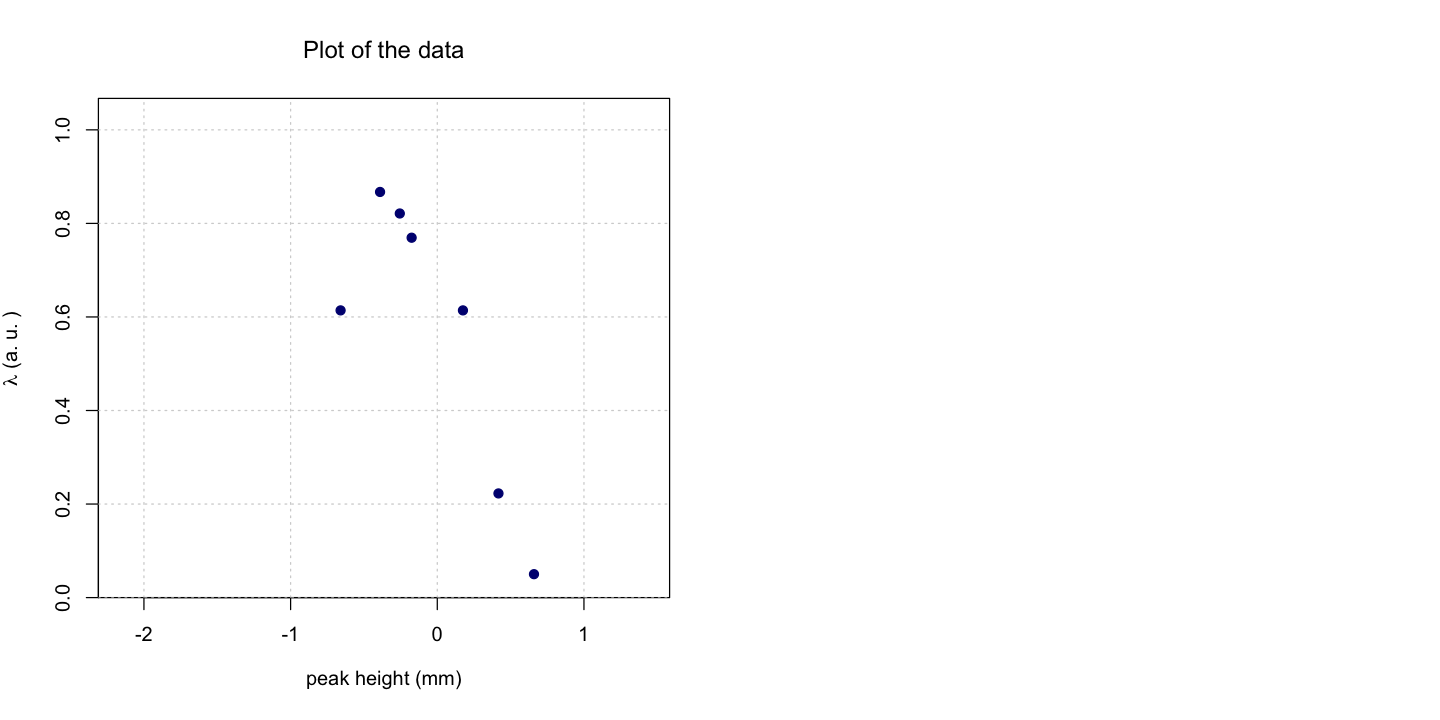

In [3]:
# Plot of data

# set the size and position of the plot
par(mfrow=c(1,2))
options(repr.plot.width=12, repr.plot.height=6)

plot(obsdata$x, obsdata$y, xaxs='r', yaxs='i', col='navy', type='p', ylim=c(0,max(y.data)+0.2), 
     main = TeX(sprintf("Plot of the data")), pch=19, xlab=TeX(sprintf("peak height (mm)")), 
     ylab=TeX(sprintf("$\\lambda$ (a.u.)")))
grid()

Assume a quadratic dependence of the peak height, $y_i$ as a function of the source position $x_i$:
$$
f(x) = c_0 + c_1 x + c_2 x^2
$$

All the measured values are affected by a Gaussian noise with zero mean, such that:
$$
y_i = f(x_i) + \epsilon
$$
where $\epsilon$ follows a normal distribution with mean $\mu = 0$ and unknown standard deviation, $\sigma$.

### A) Build a Markov Chain Monte Carlo to estimate the best parameters of the quadratic dependence of the data and the noise that affects the measured data.

Define the Metropolis Algorithm.

In [4]:
# Metropolis (MCMC) algorithm to sample from function func.
# The first argument of func must be a real vector of parameters, 
# the initial values of which are provided by the real vector thetaInit.
# func() returns a two-element vector, the logPrior and logLike 
# (log base 10), the sum of which is taken to be the log of the density 
# function (i.e. unnormalized posterior). If you don't have this separation,
# just set func to return one of them as zero. The MCMC sampling PDF is the 
# multivariate Gaussian with fixed covariance, sampleCov. A total of 
# Nburnin+Nsamp samples are drawn, of which the last Nsamp are kept. As the 
# sampling PDF is symmetric, the Hasting factor cancels, leaving the basic 
# Metropolis algorithm. Diagnostics are printed very verbose^th sample: 
# sample number, acceptance rate so far.
# ... is used to pass data, prior parameters etc. to func().
# If demo=FALSE (default), then
# return a Nsamp * (2+Ntheta) matrix (no names), where the columns are
# 1:  log prior PDF
# 2:  log likelihood
# 3+: Ntheta parameters
# (The order of the parameters in thetaInit and sampleCov must match.)
# If demo=TRUE, return the above (funcSamp) as well as thetaPropAll, a 
# Nsamp * Ntheta matrix of proposed steps, as a two element named list.

# Define the Metropolis Algorithm
metrop <- function(func, thetaInit, Nburnin, Nsamp, sampleCov, verbose, 
                   demo=FALSE, ...) {

  Ntheta   <- length(thetaInit)
  thetaCur <- thetaInit
  funcCur  <- func(thetaInit, ...) # log10
  funcSamp <- matrix(data=NA, nrow=Nsamp, ncol=2+Ntheta) 
  # funcSamp will be filled and returned
  nAccept  <- 0
  acceptRate <- 0
  if(demo) {
    thetaPropAll <- matrix(data=NA, nrow=Nsamp, ncol=Ntheta)
  }
  
  for(n in 1:(Nburnin+Nsamp)) {

    # Metropolis algorithm. No Hastings factor for symmetric proposal
    if(is.null(dim(sampleCov))) { # theta and sampleCov are scalars
      thetaProp <- rnorm(n=1, mean=thetaCur, sd=sqrt(sampleCov))
    } else {
      thetaProp <- rmvnorm(n=1, mean=thetaCur, sigma=sampleCov, 
                           method="eigen")
    }
    funcProp  <- func(thetaProp, ...) 
    logMR <- sum(funcProp) - sum(funcCur) # log10 of the Metropolis ratio
    #cat(n, thetaCur, funcCur, ":", thetaProp, funcProp, "\n")
    if(logMR>=0 || logMR>log10(runif(1, min=0, max=1))) {
      thetaCur   <- thetaProp
      funcCur    <- funcProp
      nAccept    <- nAccept + 1
      acceptRate <- nAccept/n
    }
    if(n>Nburnin) {
      funcSamp[n-Nburnin,1:2] <- funcCur
      funcSamp[n-Nburnin,3:(2+Ntheta)] <- thetaCur
      if(demo) {
        thetaPropAll[n-Nburnin,1:Ntheta] <- thetaProp
      }
    }

    # Diagnostics
    if( is.finite(verbose) && (n%%verbose==0 || n==Nburnin+Nsamp) ) {
      s1 <- noquote(formatC(n,          format="d", digits=5, flag=""))
      s2 <- noquote(formatC(Nburnin,    format="g", digits=5, flag=""))
      s3 <- noquote(formatC(Nsamp,      format="g", digits=5, flag=""))
      s4 <- noquote(formatC(acceptRate, format="f", digits=4, width=7, 
                            flag=""))
      cat(s1, "of", s2, "+", s3, s4, "\n")
    }

  }

  if(demo) {
    return(list(funcSamp=funcSamp, thetaPropAll=thetaPropAll))
  } else {
    return(funcSamp)
  }
 
}

Build the Prior:
* A Gaussian prior is used on $c_0$,$c_0 \sim N(0,10)$
* $c_1$ is transformed to $\alpha = \arctan c_1$, and a uniform prior is used $\alpha \sim U(0,2\pi)$
* A Gaussian prior is used on $c_2$, $c_2 \sim N(0,5)$
* $\sigma$ is transformed to $\log \sigma$ and an improper uniform prior is used

Given these priors, the model parameters are now $(c_0 , \alpha, c_2, \log \sigma)$. These are the parameters that the Monte Carlo algorithm will sample over. 

In [5]:
# theta is vector of parameters defined as follow:
#theta[1] -> c_0 
#theta[2] -> alpha 
#theta[3] -> c_2 
#theta[4] -> log(sigma)

# Return log10(unnormalized prior)
logprior.quadraticmodel <- function(theta) {
    c0Prior      <- dnorm(theta[1], mean=0, sd=10)
    alphaPrior   <- 1
    c2Prior      <- dnorm(theta[3], mean=0, sd=5)
    logysigPrior <- 1 
    logPrior <- sum( log10(c0Prior), log10(alphaPrior), log10(c2Prior), log10(logysigPrior) )
    return(logPrior)
}

Build the Likelihood:

In [6]:
# obsdata is 2 column dataframe with names [x,y].

# Return log10(likelihood) for parameters theta and obsdata
# dnorm(..., log=TRUE) returns log base e, so multiply by 1/ln(10) = 0.4342945
# to get log base 10
loglike.quadraticmodel <- function(theta, obsdata) {
    # convert alpha to c_1 and log10(ysig) to ysig
    theta[2] <- tan(theta[2])
    theta[4] <- 10^theta[4]
    modPred <- drop( theta[1:3] %*% t(cbind(1,obsdata$x,obsdata$x^2)) )
    # Dimensions in above mixed vector/matrix multiplication: [Ndat] = [P] %*% [P x Ndat] 
    logLike <- (1/log(10))*sum( dnorm(modPred - obsdata$y, mean=0, sd=theta[4], log=TRUE) )
    return(logLike)
}

Build the Posterior:

In [7]:
# Return c(log10(prior), log10(likelihood)) (each generally unnormalized) of the quadratic model
logpost.quadraticmodel <- function(theta, obsdata) {
    logprior <- logprior.quadraticmodel(theta)
    if(is.finite(logprior)) { # only evaluate model if parameters are sensible
        return( c(logprior, loglike.quadraticmodel(theta, obsdata)) )
    } else {
        return( c(-Inf, -Inf) )
    }
}

Build the model to infer: quadratic regression with Gaussian noise.

In [8]:
# Define covariance matrix of MCMC sampling PDF: sigma=c_0, alpha, c_2, log10(ysig))
sampleCov <- diag(c(0.1, 0.01, 0.01, 0.01)^2)

# Need fewer samples if initialize better: do a least squares fit and
# set thetaInit to: lsfit$coefficients, sqrt(mean(lsfit$residuals^2))
lsfit <- lm(y ~ x + I(x^2), data=obsdata)
#summary(lsfit)
thetaInit <- c(lsfit$coefficients,sqrt(mean(lsfit$residuals^2)))

# Run the MCMC to find postSamp, samples of the posterior PDF
set.seed(250)
allSamp <- metrop(func=logpost.quadraticmodel, thetaInit=thetaInit, Nburnin=2e4, Nsamp=2e5,
                   sampleCov=sampleCov, verbose=NA, obsdata=obsdata)
# 10^(allSamp[,1]+allSamp[,2]) is the unnormalized posterior at each sample

# Make the chains thinner
thinSel  <- seq(from=1, to=nrow(allSamp), by=100) # thin by factor 100
postSamp <- allSamp[thinSel,]

Plot of the MCMC chains.

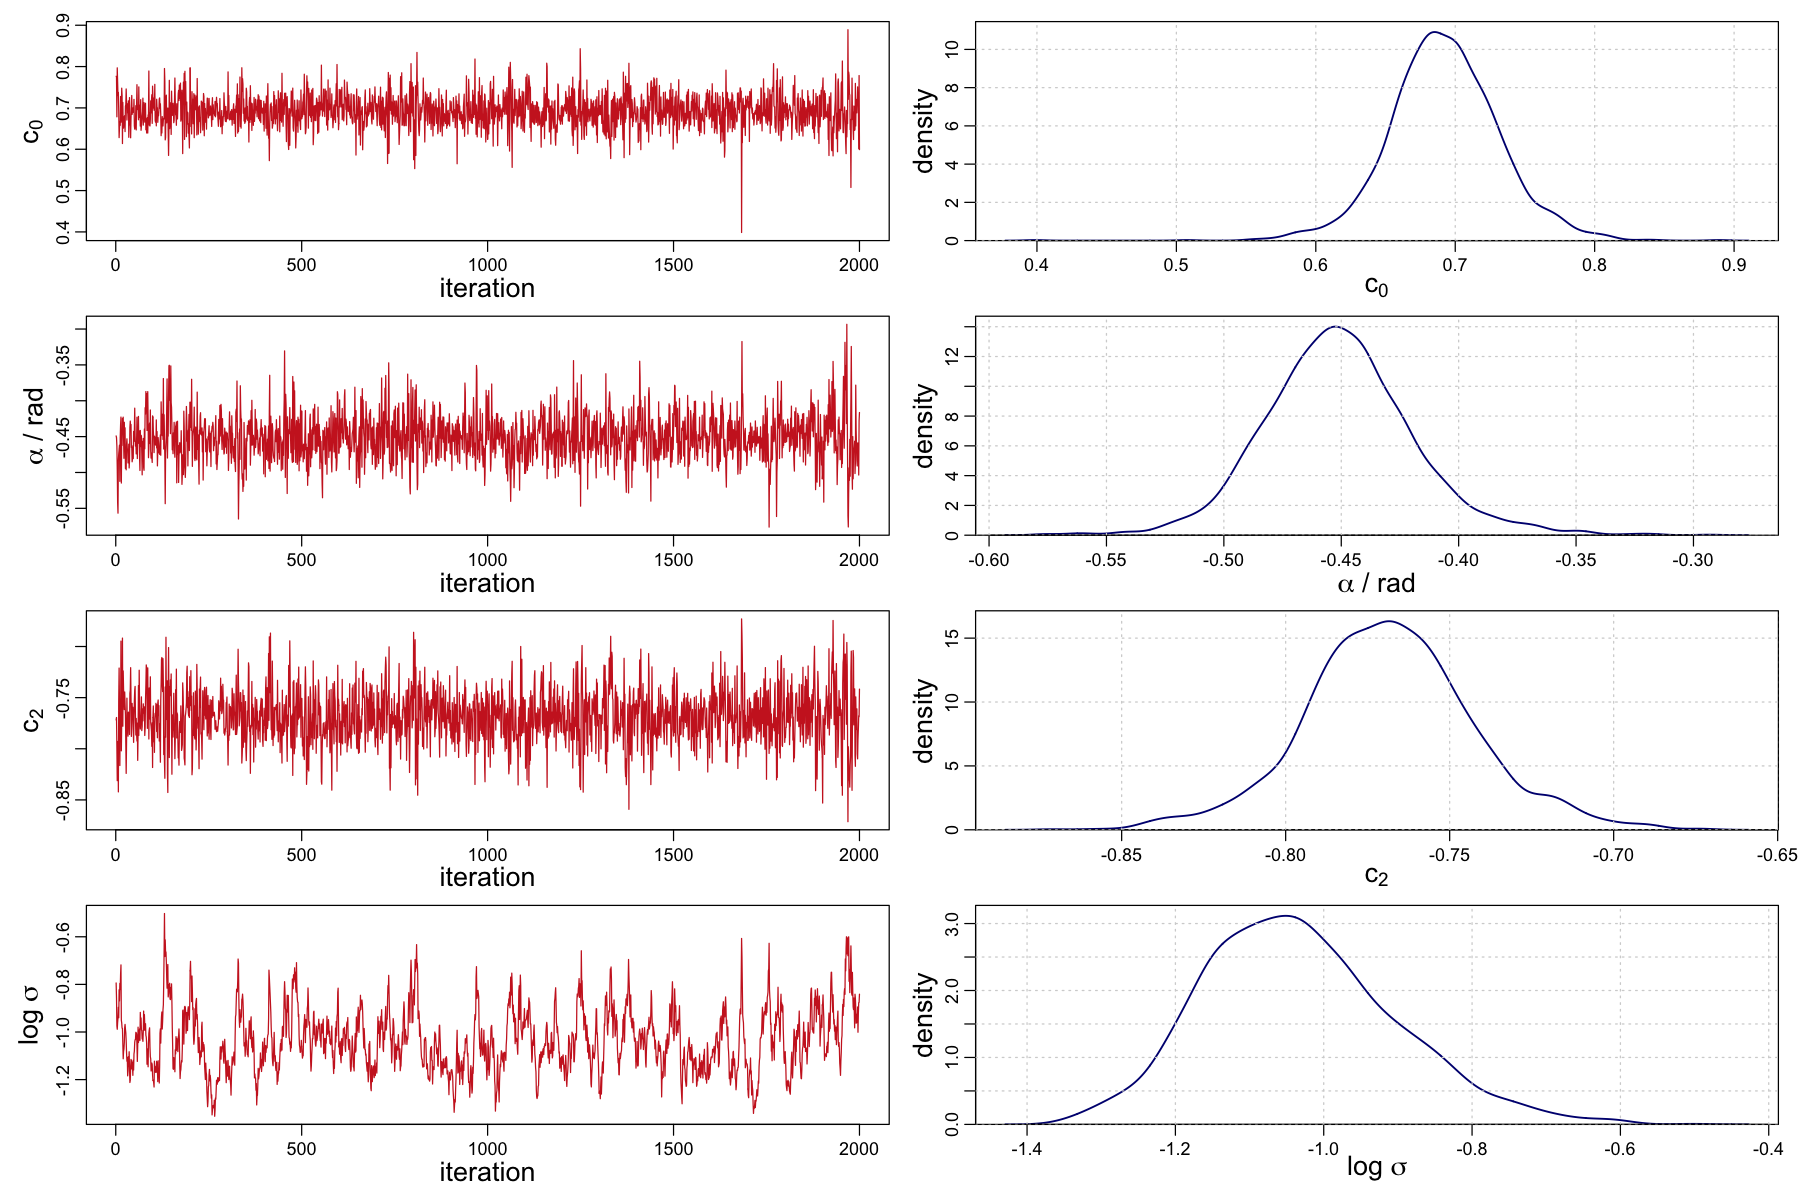

In [9]:
# Plot MCMC chains and use density estimation to plot 1D posterior PDFs from these.
# Note that we don't need to do any explicit marginalization to get the 1D PDFs.

# set the size and position of the plot
par(mfrow=c(4,2), mar=c(3.0,3.5,0.5,0.5), oma=0.5*c(1,1,1,1), mgp=c(1.8,0.6,0), cex=0.9)
options(repr.plot.width=15, repr.plot.height=10)

parnames <- c(expression(c[0]), expression(paste(alpha, " / rad")), expression(c[2]), 
              expression(paste(log, " ", sigma)))

for(j in 3:6) { # columns of postSamp
  plot(1:nrow(postSamp), postSamp[,j], type="l",col='firebrick3', xlab="iteration", ylab=parnames[j-2],cex.lab=1.5)
  postDen <- density(postSamp[,j], n=2^10)
  plot(postDen$x, postDen$y, type="l", lwd=1.5, col='navy',xaxs='r',yaxs="i", ylim=1.05*c(0,max(postDen$y)),
       xlab=parnames[j-2], ylab="density",cex.lab=1.5)
  grid()
}

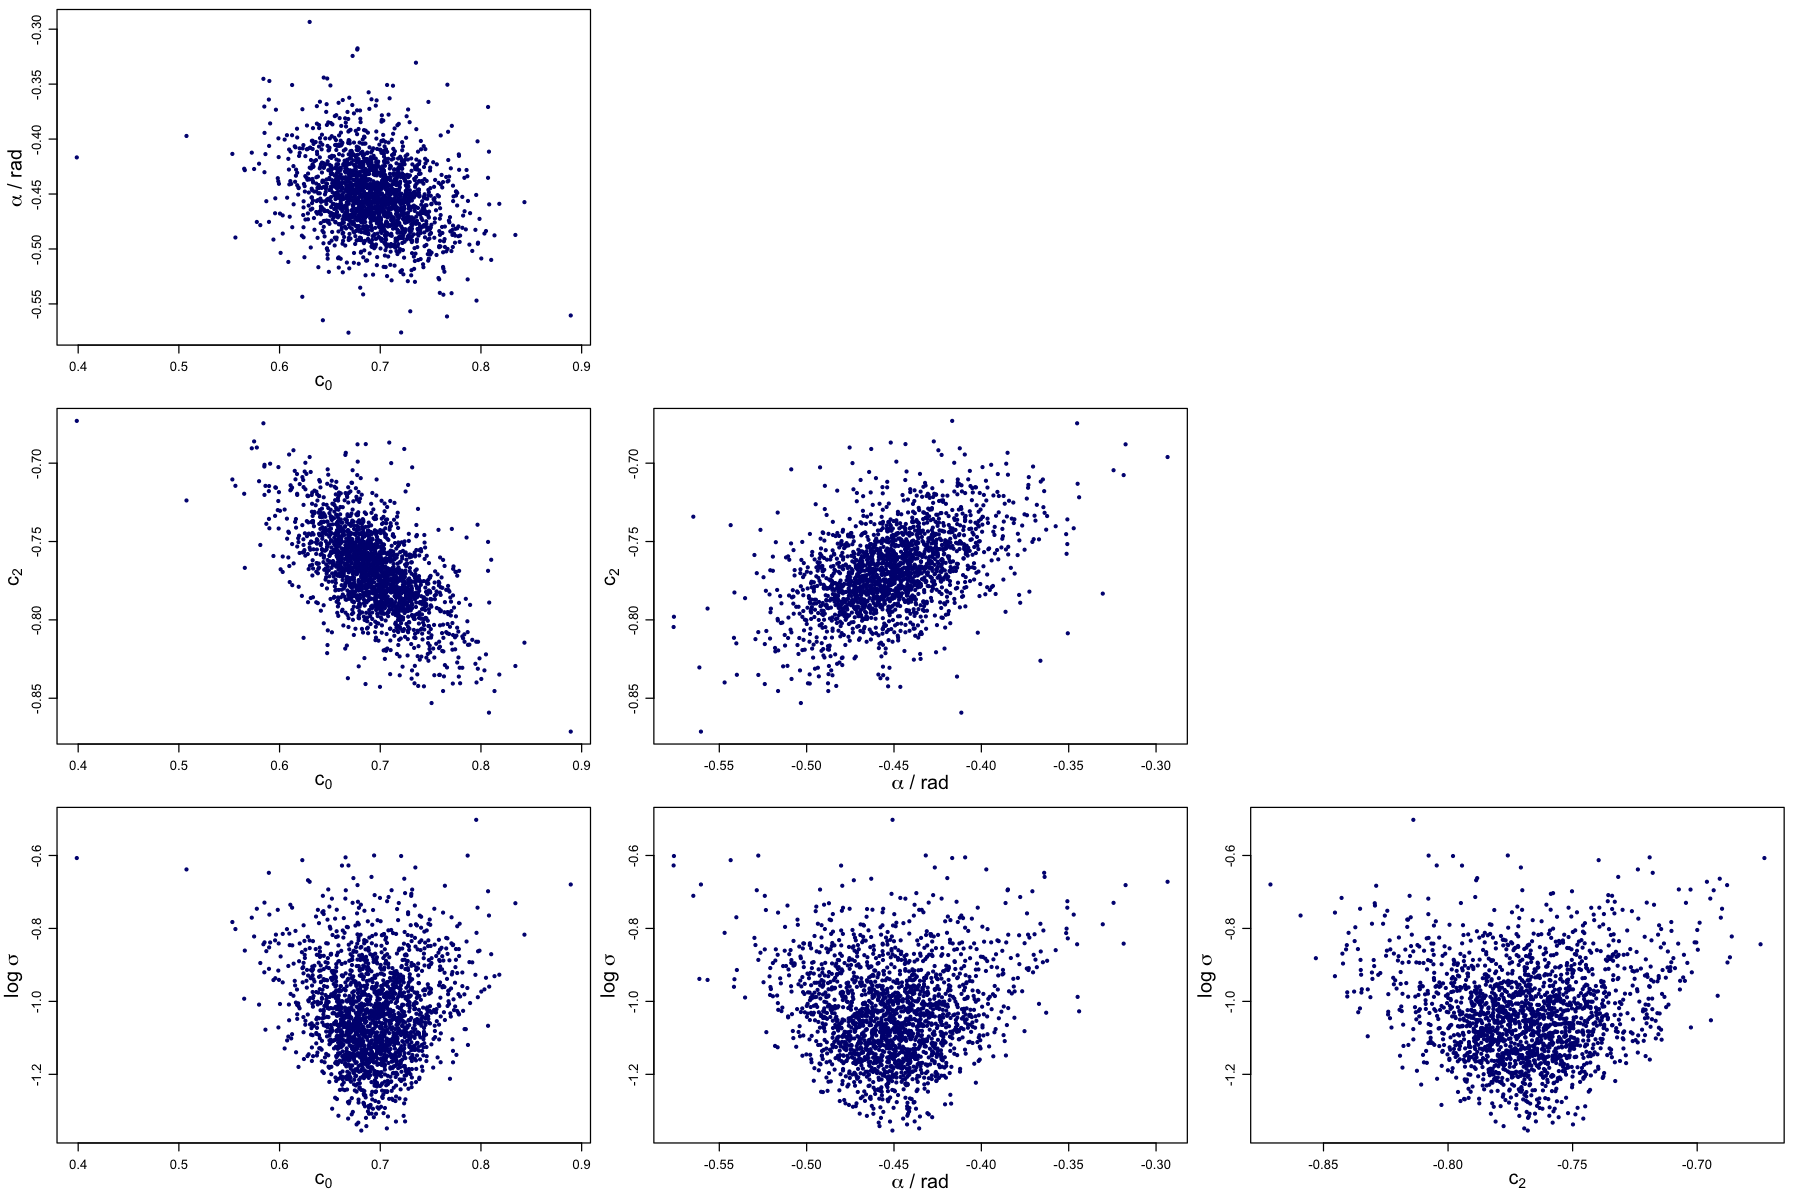

In [10]:
# Plot all parameter samples in 2D

# set the size and position of the plot
par(mfcol=c(3,3), mar=c(3.5,3.5,0.5,0.5), oma=c(0.1,0.1,0.1,0.5), mgp=c(2.0,0.8,0))
options(repr.plot.width=15, repr.plot.height=10)

for(i in 1:3) {
    for(j in 2:4) {
        if(j<=i) {
            plot.new()
        } else {
            plot(postSamp[,i+2], postSamp[,j+2], col='navy',xlab=parnames[i], ylab=parnames[j], pch=19,cex=0.5,cex.lab=1.5)
        }
    }
}

In [11]:
# Find MAP and mean solutions.
# MAP = Maximum A Posteriori, i.e. peak of posterior.
# MAP is not the peak in each 1D PDF, but the peak of the 4D PDF.
# mean is easy, because samples have been drawn from the (unnormalized) posterior.
posMAP    <- which.max(postSamp[,1]+postSamp[,2]) 
thetaMAP  <- postSamp[posMAP, 3:6]
thetaMean <- apply(postSamp[,3:6], 2, mean) # Monte Carlo integration

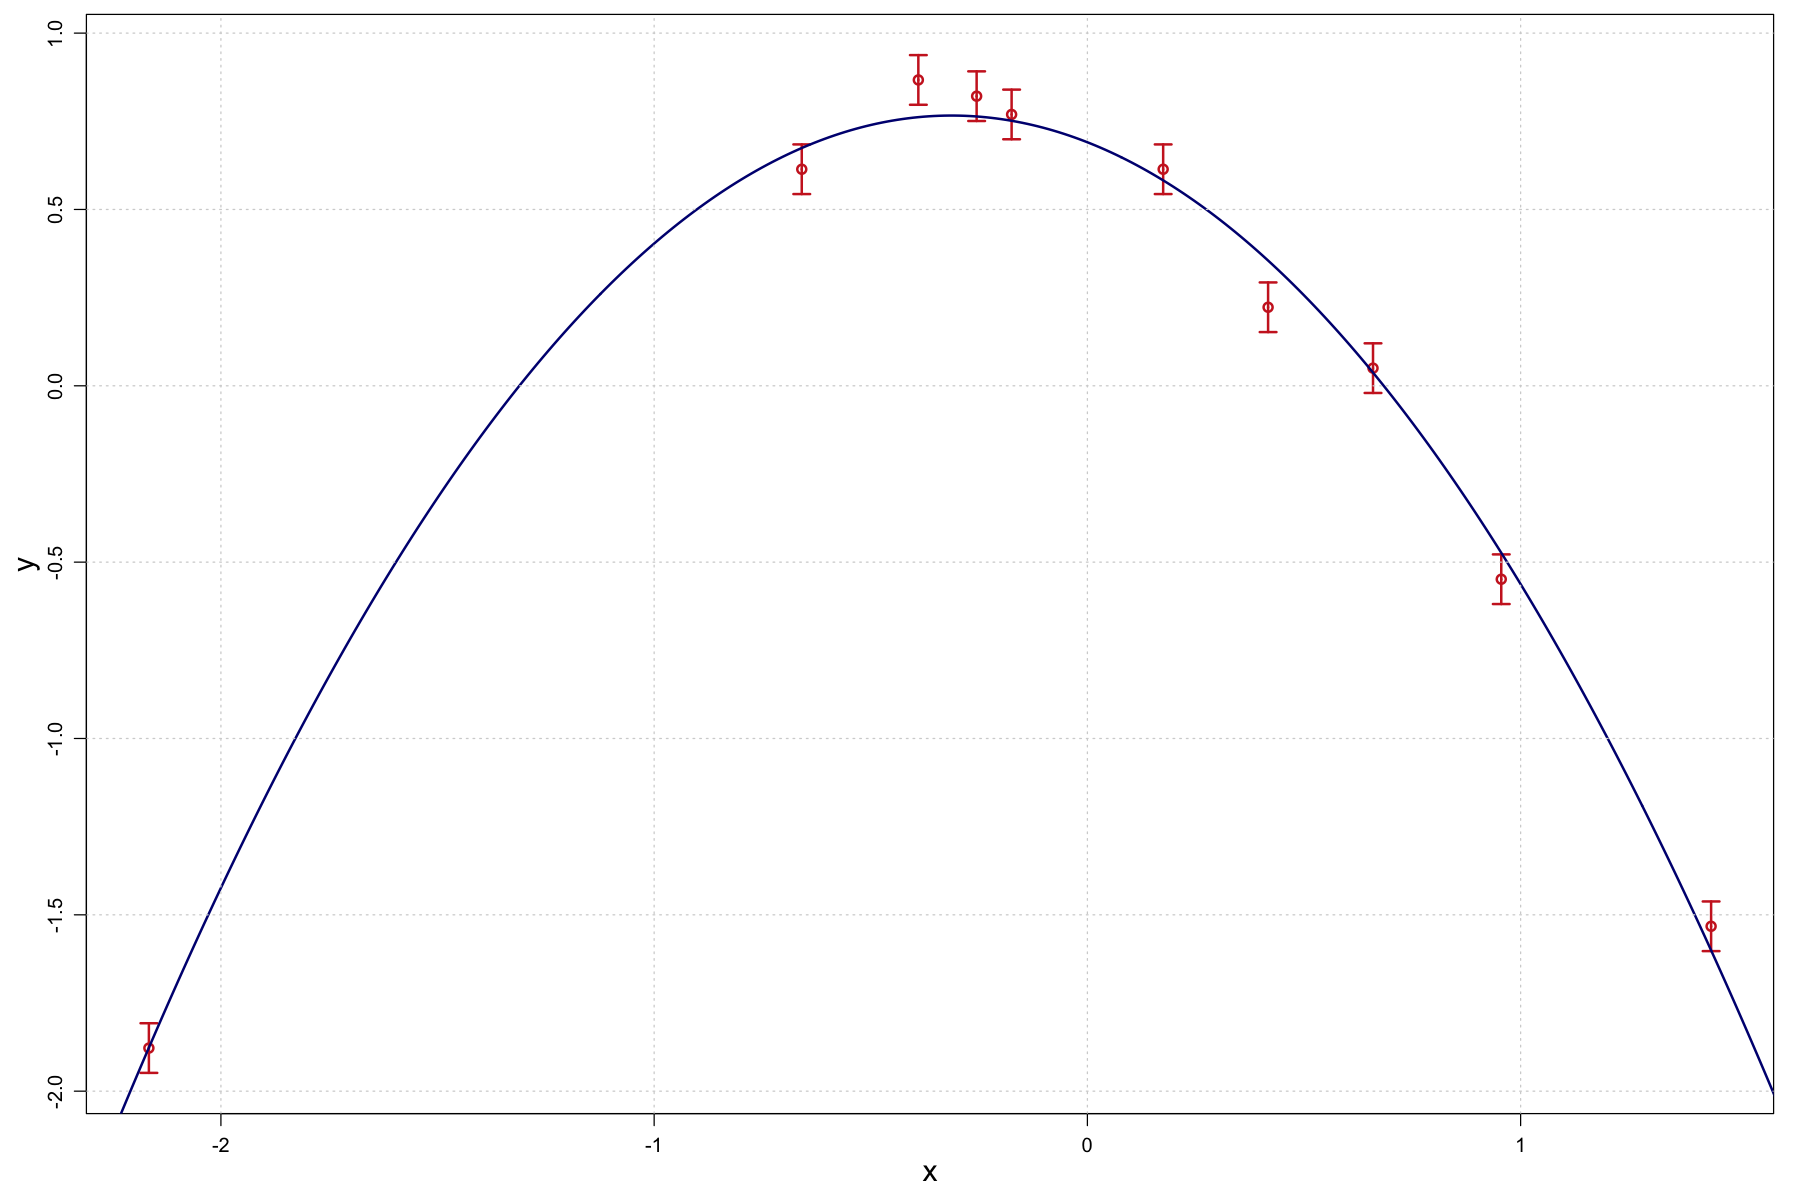

In [12]:
# Overplot MAP solution with original data

# set the size and position of the plot
par(mfrow=c(1,1), mar=c(3.5,3.5,0.5,1), oma=0.1*c(1,1,1,1), mgp=c(2.0,0.8,0), cex=1.0)
options(repr.plot.width=15, repr.plot.height=10)

plotCI(obsdata$x, obsdata$y, xlab="x", ylab="y", uiw=10^thetaMAP[4], gap=0,col='firebrick3',lwd=2,cex.lab=1.5)

xsamp <- seq(from=-3, to=3, length.out=500)
ysamp <- cbind(1,xsamp,xsamp^2) %*% as.matrix(c(thetaMAP[1], tan(thetaMAP[2]), thetaMAP[3]))

lines(xsamp, drop(ysamp), lwd=2,col='navy')
grid()

As can be seen from our data, the students forgot to take measurements in the region $x \in (2.44, 3.0)$.

### B) Run a Markov Chain Monte Carlo to predict peak height measurements at $x_1 = 2.8$ mm and $x_2 = 2.6$ mm

In [13]:
x.new1 <- 2.8
# Standardize data
x.new <- (x.new1 - mean(x.data0))/sd(x.data0)

In [14]:
# Evaluate generative model at posterior samples (from MCMC).
# Dimensions in matrix multiplication: [Nsamp x 1] = [Nsamp x P] %*% [P x 1]
modPred <- cbind(postSamp[,3], tan(postSamp[,4]),postSamp[,5]) %*% t(cbind(1,x.new,(x.new^2)))

#### Generate $x_1$ in both direct and indirect method

##### Direct method

In [15]:
set.seed(250)
# to center choice of ycand
dy <- 0.01
ymid <- thetaMAP[1] + x.new*tan(thetaMAP[2]) + (x.new^2) * thetaMAP[3]  + rnorm(1, mean=0, sd=10^thetaMAP[4])
# uniform grid of y with step size dy
ycand <- seq(ymid-1, ymid+1, dy) 
ycandPDF <- vector(mode="numeric", length=length(ycand))

At a fixed value of $y_p$ we take our set of $N_s$ posterior samples $\{ \theta_l \}$ (obtained by MCMC), calculate the likelihood at each of these, and then average these likelihoods, i.e.:
$$
P(y_p|x_p D) \sim \frac{1}{N_s} \sum_{j=1}^{N_s} P(y_p|x_p \theta_j)
$$

In [16]:
for(k in 1:length(ycand)) {
    like <- dnorm(ycand[k], mean=modPred, sd=10^postSamp[,6]) # [Nsamp x 1] 
    ycandPDF[k] <- mean(like) # integration by rectangle rule. Gives a scalar
}

cat("Check if ycandPDF is normalized: area =",sum(dy*ycandPDF))

Check if ycandPDF is normalized: area = 0.9999973

The posterior predictive distribution is a posterior-weighted average of the predictions (the likelihood) made at each $\theta$.

In [17]:
# Find peak and approximate confidence intervals at 1sigma on either side 
peak.ind <- which.max(ycandPDF)

lower.ind <- max( which(cumsum(dy*ycandPDF) < pnorm(-1)) )
upper.ind <- min( which(cumsum(dy*ycandPDF) > pnorm(+1)) )

yPredDirect <- ycand[c(peak.ind, lower.ind, upper.ind)]

##### Indirect method

As the likelihood is a uni-variate Gaussian, it may be sampled using a standard function.
Its mean is the evaluation of the straight line at $(c_0,c_1,c_2)$, and its standard deviation is $\sigma$.

In [18]:
likeSamp <- rnorm(n=length(modPred), mean=modPred, sd=10^postSamp[,6])
likeDen <- density(likeSamp, n=2^10)

yPredIndirect <- c(likeDen$x[which.max(likeDen$y)], 
                   quantile(likeSamp, probs=c(pnorm(-1), pnorm(+1)), names=FALSE))

##### Comparison

[,1]      [,2]       [,3]     
yPredDirect   0.1705209 0.06052085 0.2705209
yPredIndirect 0.1641989 0.06802266 0.2816075

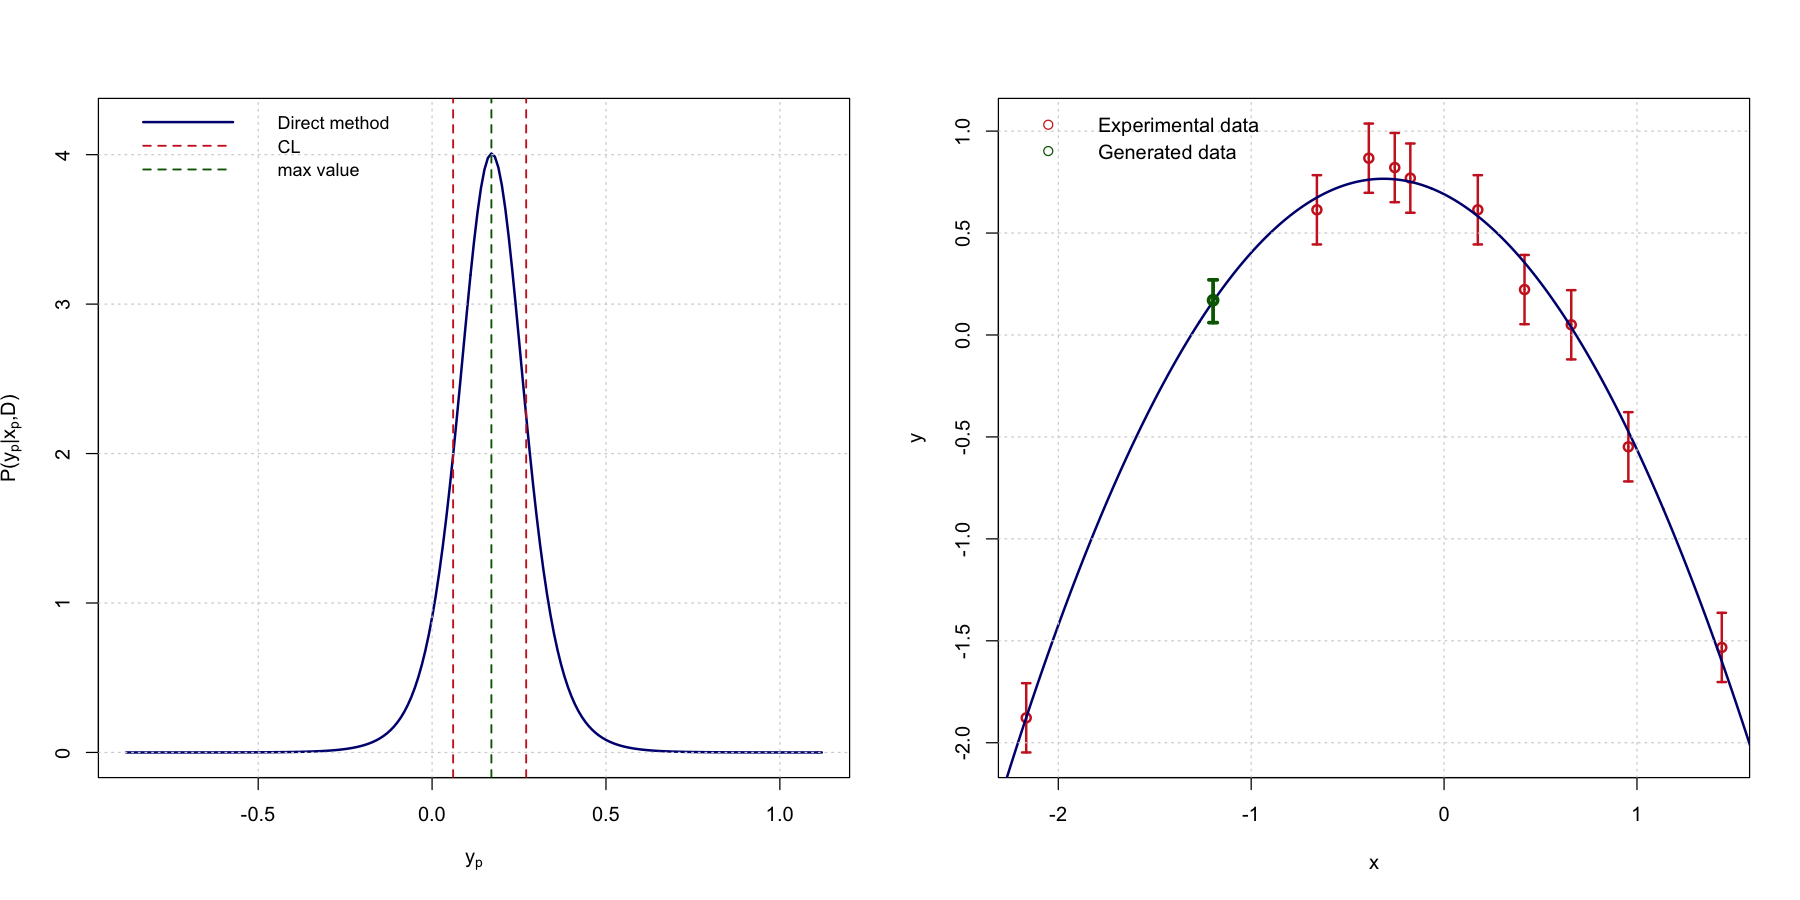

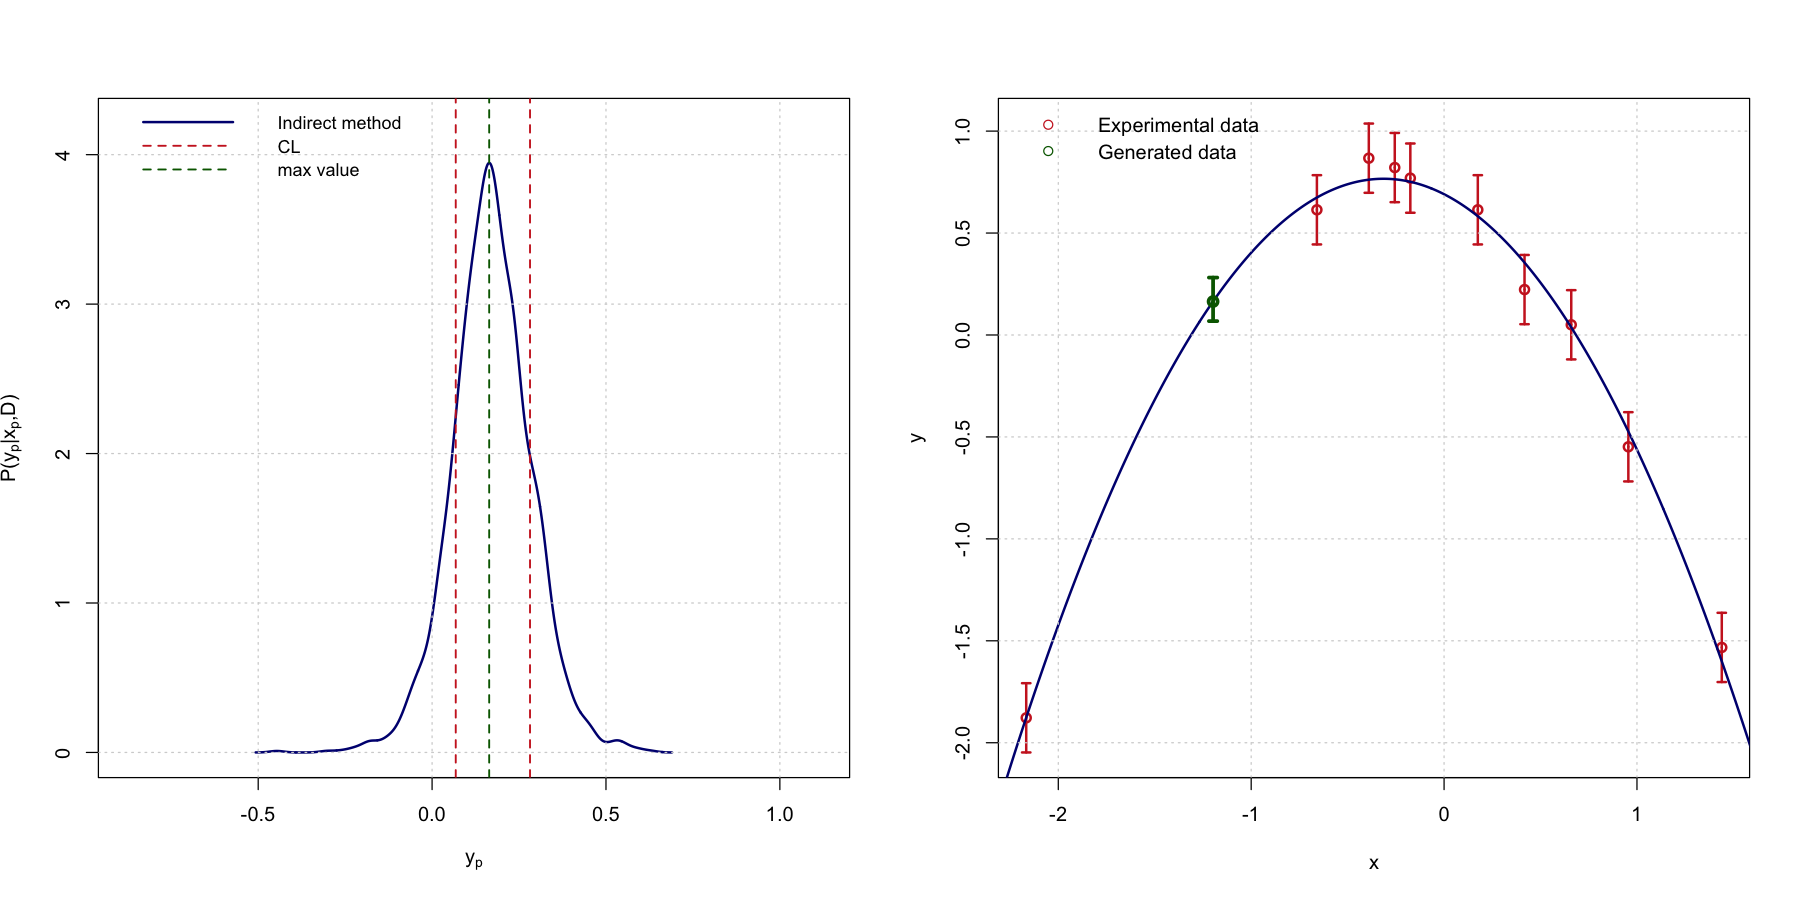

In [19]:
# Table of results
rbind(yPredDirect , yPredIndirect)

# Plot results of the two methods

# set the size and position of the plot
par(mfrow=c(1,2))
options(repr.plot.width=15, repr.plot.height=7.5)

# DIRECT METHOD
plot(ycand, ycandPDF, type="l", lwd=2, col="navy",xlim=c(min(ycand),max(ycand)),ylim=1.05*c(0,max(ycandPDF)), xlab=expression(y[p]), 
     ylab=expression(paste("P(", y[p], "|", x[p], ",D)")))
abline(v=yPredDirect[c(2,3)], col="firebrick3", lty=2, lwd=1.5)
abline(v=yPredDirect[1], col="darkgreen", lty=2, lwd=1.5)

legend("topleft", inset=0,legend=c("Direct method","CL","max value"),
       col=c("navy","firebrick3","darkgreen"), lty=c(1,2,2), lwd=c(2,1.5,1.5), cex=0.9,box.lty=0)
grid()

# Overplot direct prediction with original data and the MAP model
plotCI(obsdata$x, obsdata$y, uiw=10^thetaMAP[3], gap=0, xlab="x", ylab="y",col='firebrick3',lwd=2)
lines(xsamp, drop(ysamp), lwd=2,col='navy')
plotCI(x.new, ycand[peak.ind], li=ycand[lower.ind], ui=ycand[upper.ind], gap=0, add=TRUE, lwd=3, col="darkgreen")
grid()
legend("topleft", inset=0,legend=c("Experimental data","Generated data"),
       col=c("firebrick3","darkgreen"), pch=c(1,1),cex=1,box.lty=0)


# INDIRECT METHOD

# set the size and position of the plot
par(mfrow=c(1,2))
options(repr.plot.width=15, repr.plot.height=7.5)

plot(likeDen$x, likeDen$y, type="l", lwd=2, col="navy",xlim=c(min(ycand),max(ycand)),ylim=1.05*c(0,max(ycandPDF)), xlab=expression(y[p]), 
     ylab=expression(paste("P(", y[p], "|", x[p], ",D)")))
abline(v=yPredIndirect[c(2,3)], col="firebrick3", lty=2, lwd=1.5)
abline(v=yPredIndirect[1], col="darkgreen", lty=2, lwd=1.5)

legend("topleft", inset=0,legend=c("Indirect method","CL","max value"),
       col=c("navy","firebrick3","darkgreen"), lty=c(1,2,2), lwd=c(2,1.5,1.5), cex=0.9,box.lty=0)
grid()

# Overplot direct prediction with original data and the MAP model
plotCI(obsdata$x, obsdata$y, uiw=10^thetaMAP[3], gap=0, xlab="x", ylab="y",col='firebrick3',lwd=2)
lines(xsamp, drop(ysamp), lwd=2,col='navy')
plotCI(x.new, yPredIndirect[1], li=yPredIndirect[2], ui=yPredIndirect[3], gap=0, add=TRUE, lwd=3, col="darkgreen")
grid()

legend("topleft", inset=0,legend=c("Experimental data","Generated data"),
       col=c("firebrick3","darkgreen"), pch=c(1,1),cex=1,box.lty=0)


#### Generate $x_2$ with indirect method

In [20]:
x.new2 <- 2.6
# Standardize data
x.new2 <- (x.new2 - mean(x.data0))/sd(x.data0)

modPred <- cbind(postSamp[,3], tan(postSamp[,4]),postSamp[,5]) %*% t(cbind(1,x.new2,(x.new2^2)))

likeSamp2 <- rnorm(n=length(modPred), mean=modPred, sd=10^postSamp[,6])
likeDen2 <- density(likeSamp2, n=2^10)

yPredIndirect2 <- c(likeDen2$x[which.max(likeDen2$y)], 
                   quantile(likeSamp2, probs=c(pnorm(-1), pnorm(+1)), names=FALSE))


#### Plot of generated samples $x_1$ and $x_2$ with indirect method

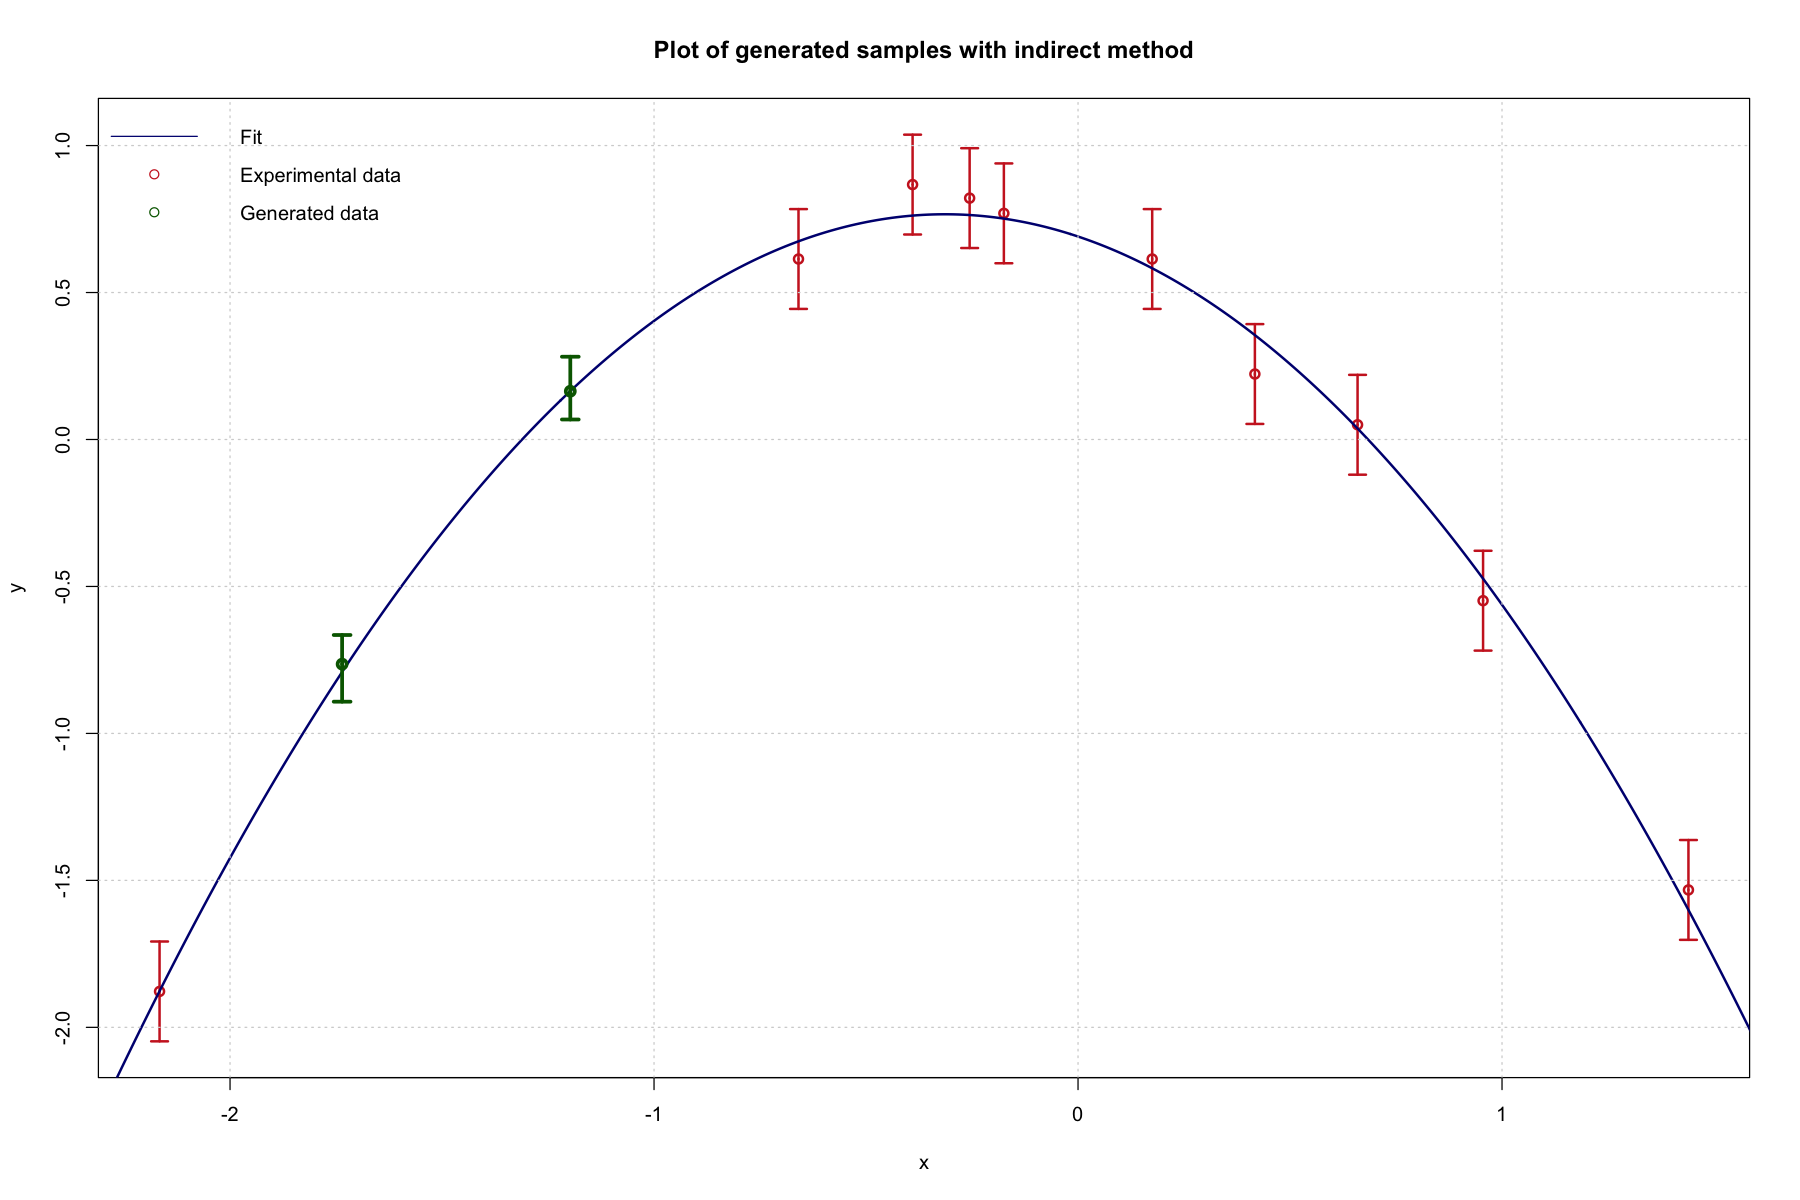

In [21]:
# Plot generated samples with INDIRECT METHOD

# set the size and position of the plot
par(mfrow=c(1,1))
options(repr.plot.width=15, repr.plot.height=10)

# Overplot direct prediction with original data and the MAP model
plotCI(obsdata$x, obsdata$y, uiw=10^thetaMAP[3], gap=0, xlab="x", ylab="y",col='firebrick3',lwd=2,
      main="Plot of generated samples with indirect method")
lines(xsamp, drop(ysamp), lwd=2,col='navy')
plotCI(x.new, yPredIndirect[1], li=yPredIndirect[2], ui=yPredIndirect[3], gap=0, add=TRUE, lwd=3, col="darkgreen")
plotCI(x.new2, yPredIndirect2[1], li=yPredIndirect2[2], ui=yPredIndirect2[3], gap=0, add=TRUE, lwd=3, col="darkgreen")
grid()
legend("topleft", inset=0,legend=c("Fit","Experimental data","Generated data"),
       col=c("navy","firebrick3","darkgreen"), lwd=c(1,NA,NA), pch=c(NA,1,1),cex=1,box.lty=0)

## Exercise 2 - British coal mine disasters <a class="anchor" id="2"></a>
* [Index](#0)

The number of British coal mine disasters has been recorded from 1851 to 1962. By looking at the data it seems that the number of incidents decreased towards the end of the sampling period. We model the data as follows:

* before some year, we call $\tau$, the data follow a Poisson distribution, where the logarithm of the mean value, $\log \mu_t = b_0$;
* while for later years, we can model it as $\log \mu t = b_0 + b_1$.

The dependence can be modeled as follows $y_t \sim Pois(\mu t)$, where $\log \mu t = b_0 + b_1 \text{Step}(t − \tau)$.

Implement the model in jags, trying to infer the parameters $b_0$, $b_1$ and $\tau$. 

The step function is implemented, in BUGS, as $\text{step}(x)$ and return 1 if $x \ge 0$ and 0 otherwise.

Assign a uniform prior to $b_0$, $b_1$ and a uniform prior in the interval $(1,N)$, where $N = 112$ is the number of years our data span on.

Finally, here is our data:

In [22]:
# Import data
data<- NULL
data$D <- c(4,5,4,1,0,4,3,4,0,6,3,3,4,0,
            2,6,3,3,5,4,5,3,1,4,4,1,5,5, 
            3,4,2,5,2,2,3,4,2,1,3,2,1,1, 
            1,1,1,3,0,0,1,0,1,1,0,0,3,1, 
            0,3,2,2,0,1,1,1,0,1,0,1,0,0, 
            0,2,1,0,0,0,1,1,0,2,2,3,1,1, 
            2,1,1,1,1,2,4,2,0,0,0,1,4,0,
            0,0,1,0,0,0,0,0,1,0,0,1,0,0)
data$N <-112

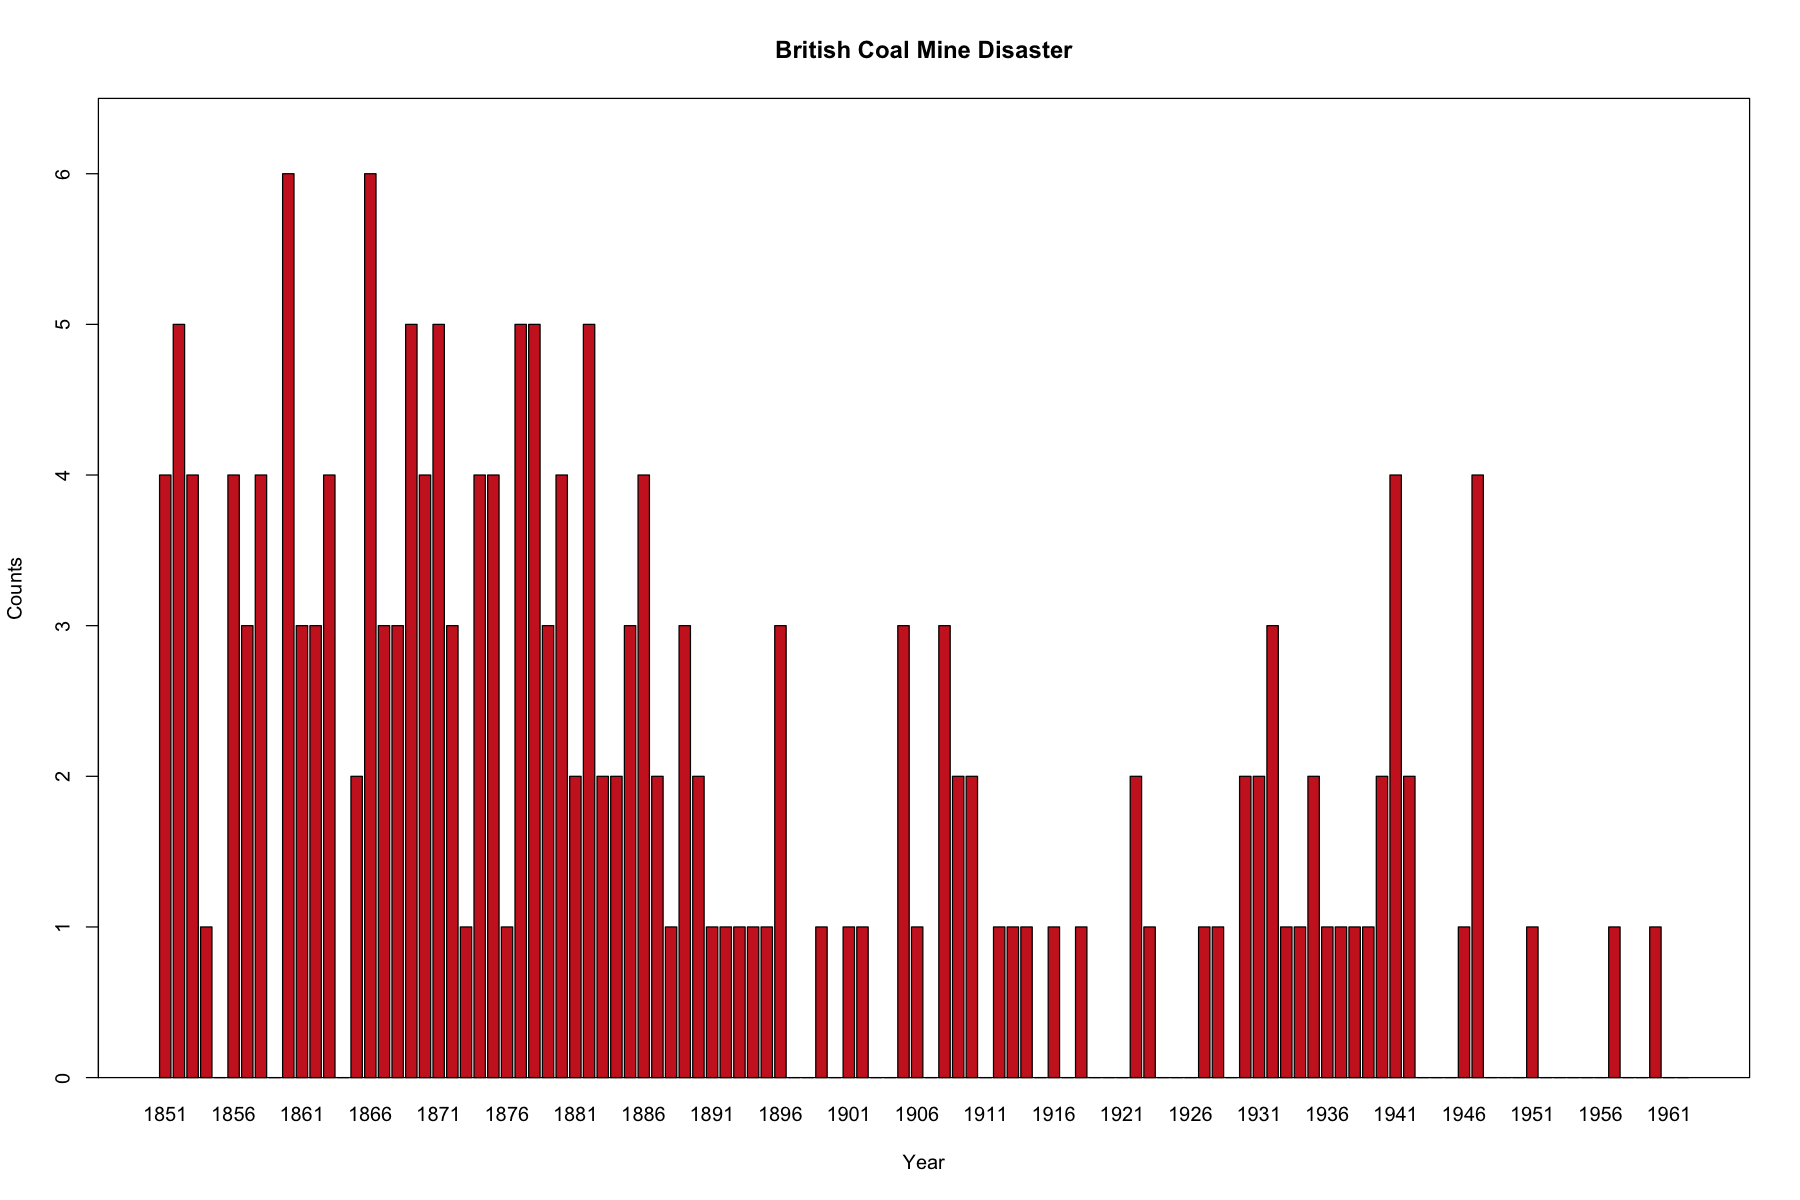

In [23]:
# Plot of the data
barplot(data$D, names=1851:1962, xlab="Year", ylab="Counts", ylim=c(0,max(data$D)+0.5),
        main="British Coal Mine Disaster", col="firebrick3")
box()

Before running jags, assign an initial value to the parameters as follows: $b_0 = 0$, $b_1 = 0$ and $\tau = 50$.

In [24]:
# Define the model and write it in a file
cat("model {
    for (t in 1:N){ 
        mu[t] <- exp(b0 + b1 * step(t-tau))
        # data likelihood
        D[t] ~ dpois(mu[t])
        # Predicted data , given b0,b1,tau
        Y[t] ~ dpois(mu[t]) 
    }
    # a uniform prior for b0,b1,tau
    b0 ~ dunif(-3,3)
    b1 ~ dunif(-3,3)
    tau ~ dunif(1,N)
    }", file="poisson_model.bug")

model <- "poisson_model.bug" 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model



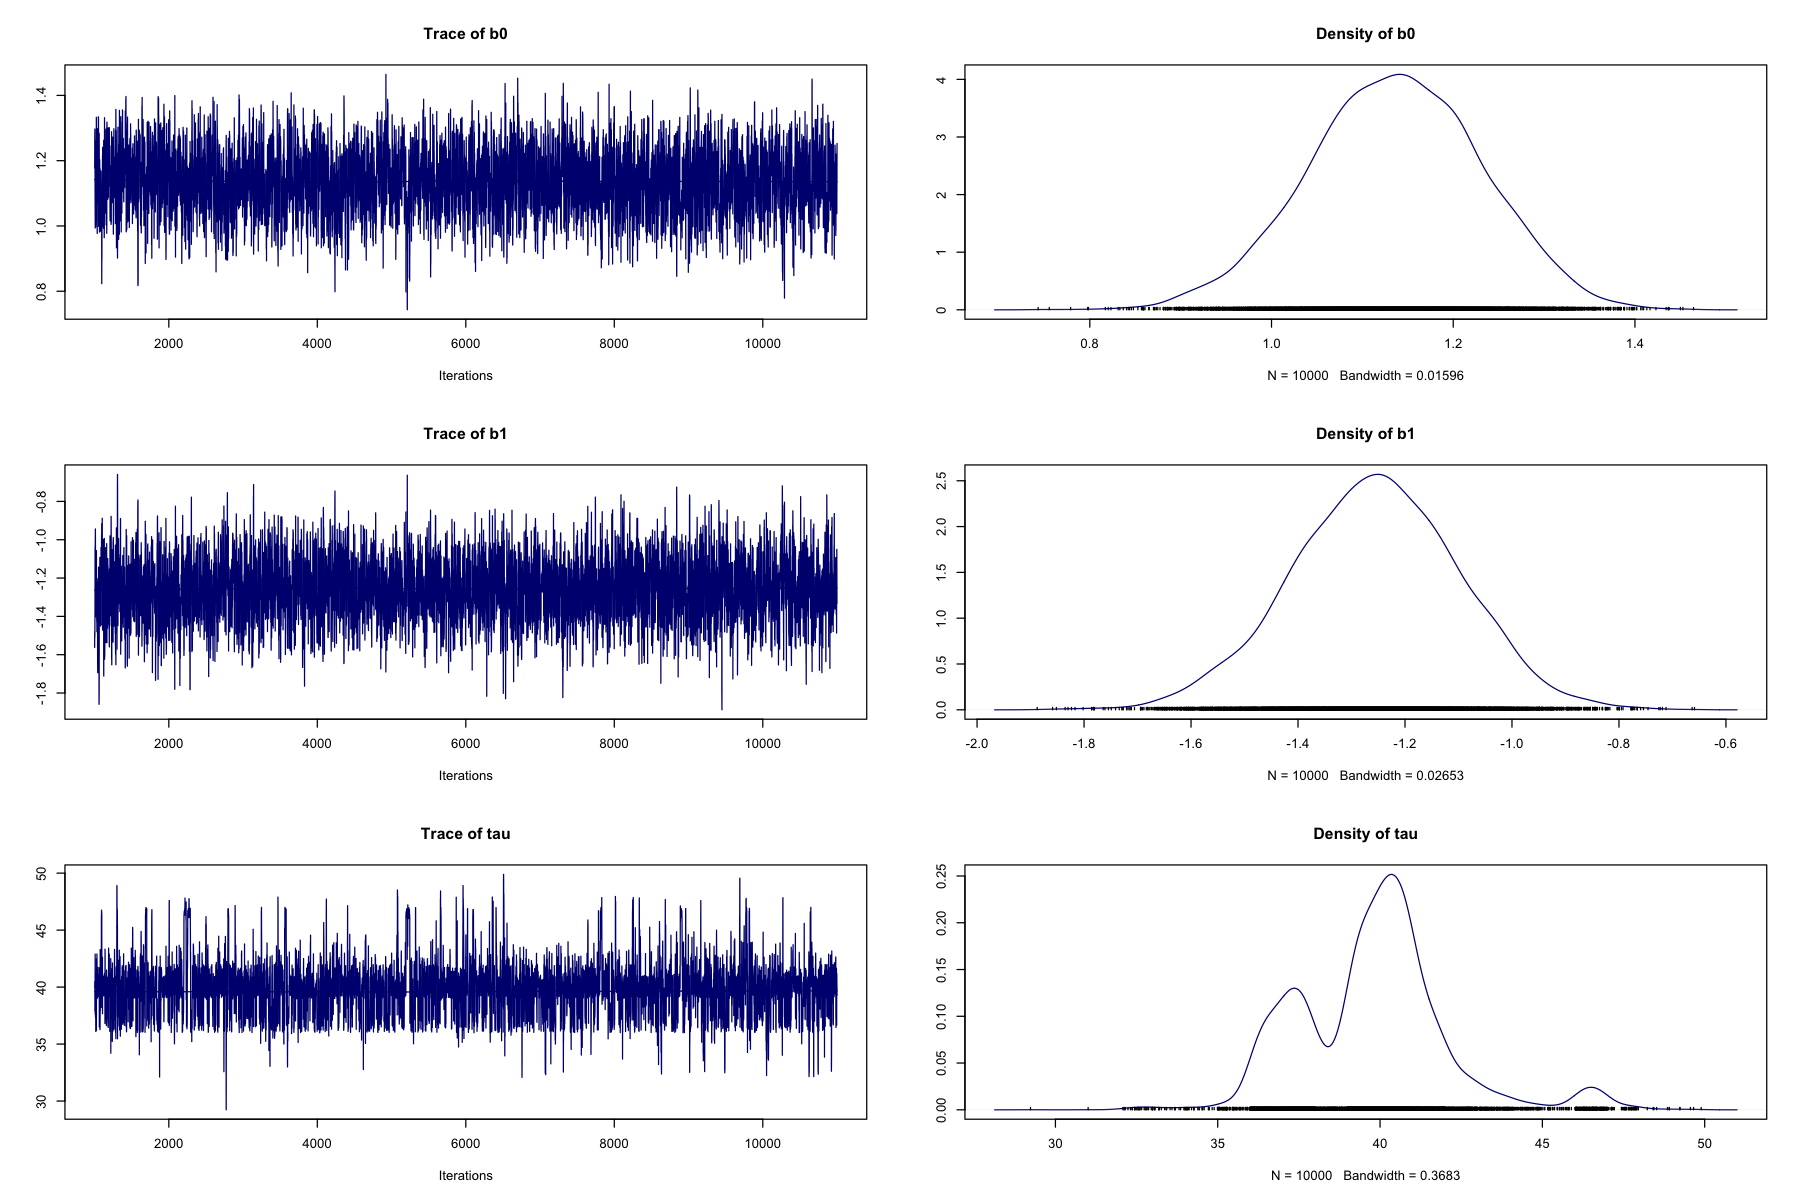

In [25]:
init <- NULL
init$b0 <- 0
init$b1 <- 0
init$tau <- 50

jm <- jags.model(model, data, init)

chain <- coda.samples(jm, c("b0","b1","tau"), n.iter=10000)

# set the size of the plot
options(repr.plot.width=15, repr.plot.height=10)
plot(chain, col="navy")

In [26]:
summary(chain)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
b0   1.136 0.09501 0.0009501       0.002017
b1  -1.257 0.15790 0.0015790       0.002953
tau 39.775 2.32831 0.0232831       0.071424

2. Quantiles for each variable:

       2.5%    25%    50%    75%   97.5%
b0   0.9431  1.072  1.137  1.201  1.3173
b1  -1.5732 -1.362 -1.255 -1.150 -0.9524
tau 36.0817 37.938 39.929 40.876 46.3141


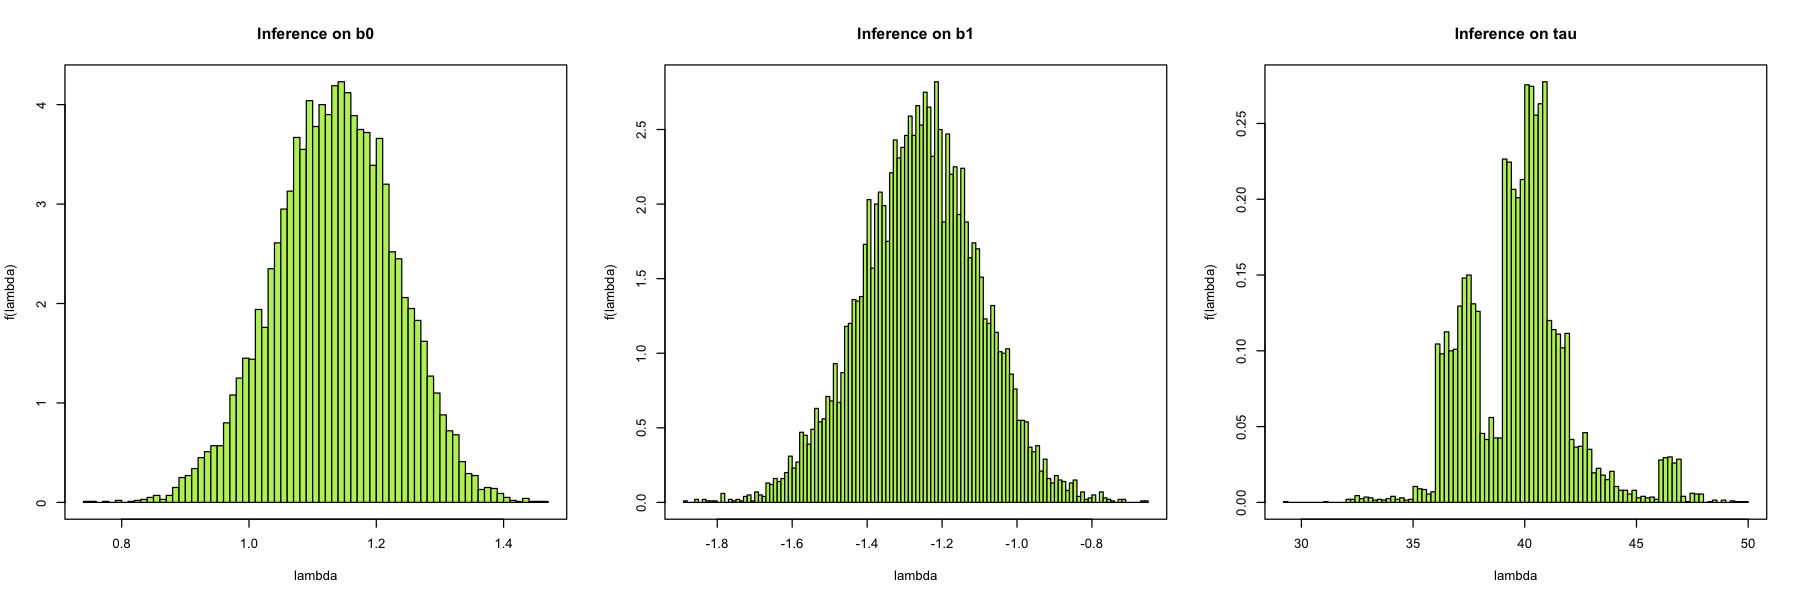

In [27]:
# Let’s format our chain
chain.df <- as.data.frame( as.mcmc(chain) )

# Probability plots

# set the size and position of the plot
options(repr.plot.width=15, repr.plot.height=5)
par(mfrow=c(1,3))

hist(chain.df$b0, nc=100, prob=TRUE, col="darkolivegreen2", 
     xlab="lambda", ylab="f(lambda)", main="Inference on b0")
box()
hist(chain.df$b1, nc=100, prob=TRUE, col="darkolivegreen2", 
     xlab="lambda", ylab="f(lambda)", main="Inference on b1")
box()
hist(chain.df$tau, nc=100, prob=TRUE, col="darkolivegreen2", 
     xlab="lambda", ylab="f(lambda)", main="Inference on tau")
box()

In [28]:
# Print correlation matrix
cat("Correlation matrix: \n")
cor(chain.df)

Correlation matrix: 


b0         b1          tau        
b0   1.0000000 -0.56307208 -0.27406544
b1  -0.5630721  1.00000000 -0.02916485
tau -0.2740654 -0.02916485  1.00000000

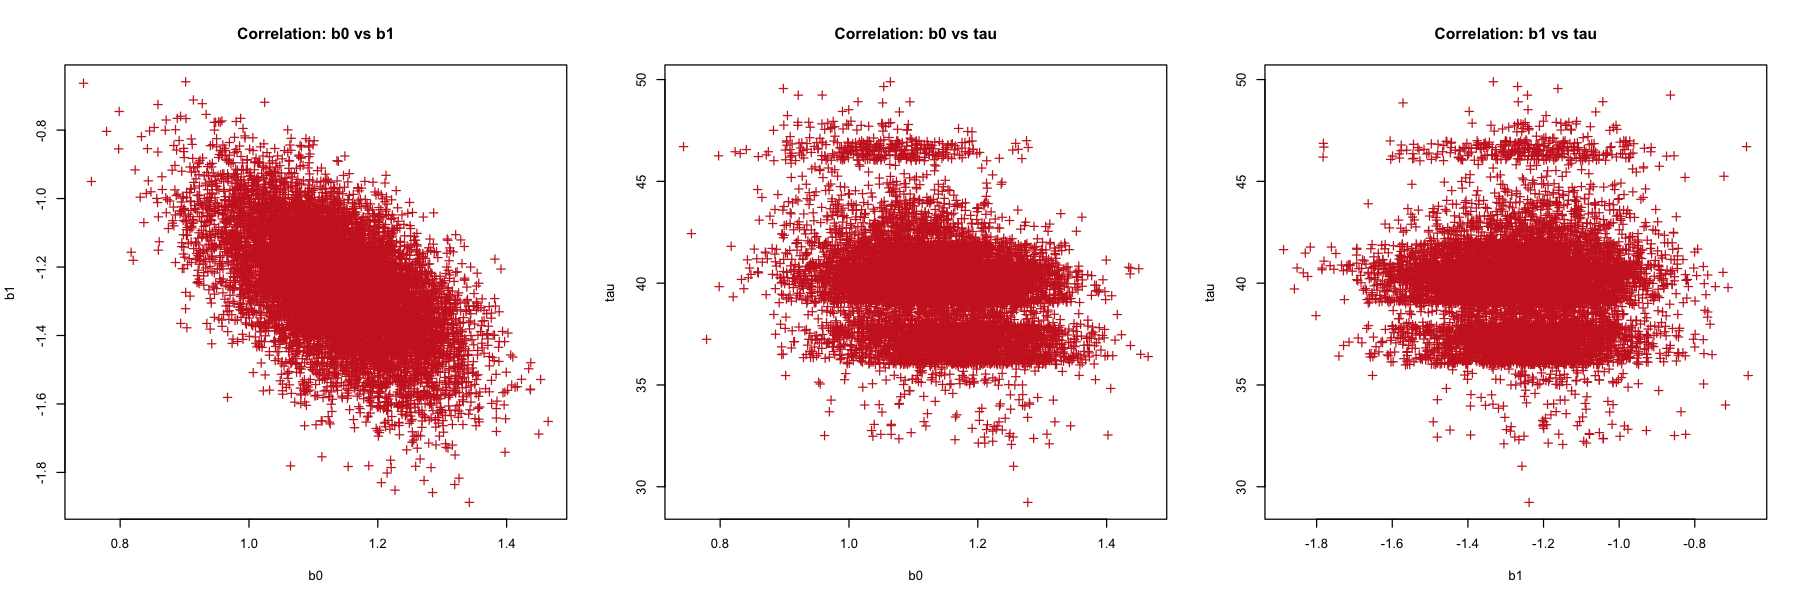

In [29]:
# set the size and position of the plot
options(repr.plot.width=15, repr.plot.height=5)
par(mfrow=c(1,3))

plot(chain.df$b0 , chain.df$b1, xlab="b0", ylab="b1", main="Correlation: b0 vs b1", 
     pch=3, col='firebrick3')
plot(chain.df$b0 , chain.df$tau, xlab="b0", ylab="tau", main="Correlation: b0 vs tau", 
     pch=3, col='firebrick3')
plot(chain.df$b1 , chain.df$tau, xlab="b1", ylab="tau", main="Correlation: b1 vs tau", 
     pch=3, col='firebrick3')

### Explore the features of the chains and try to understand the effects of the burn-in, and thinning

#### Burn-in effect

In [30]:
burnin.list <- c(1,100,200,500,1000,2000)

b0.burnin.list  <- NULL
b1.burnin.list  <- NULL
tau.burnin.list <- NULL

In [31]:
for (burnin in burnin.list) {
    
    model <- "poisson_model.bug"

    # Initialize parameters
    init <- NULL
    init$b0 <- 0
    init$b1 <- 0
    init$tau <- 50

    jm <- jags.model(model, data, init)

    # Update the Markov chain (Burn-in)
    update(jm, burnin)
    
    # Run model
    chain <- coda.samples(jm, c("b0","b1","tau"), n.iter=10000, n.thin=1)

    # Create dataframe
    chain.df <- as.data.frame( as.mcmc(chain) )
    
    # Store results 
    b0.burnin.list  <- cbind(b0.burnin.list,  chain.df[[1]])
    b1.burnin.list  <- cbind(b1.burnin.list,  chain.df[[2]])
    tau.burnin.list <- cbind(tau.burnin.list, chain.df[[3]])
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic no

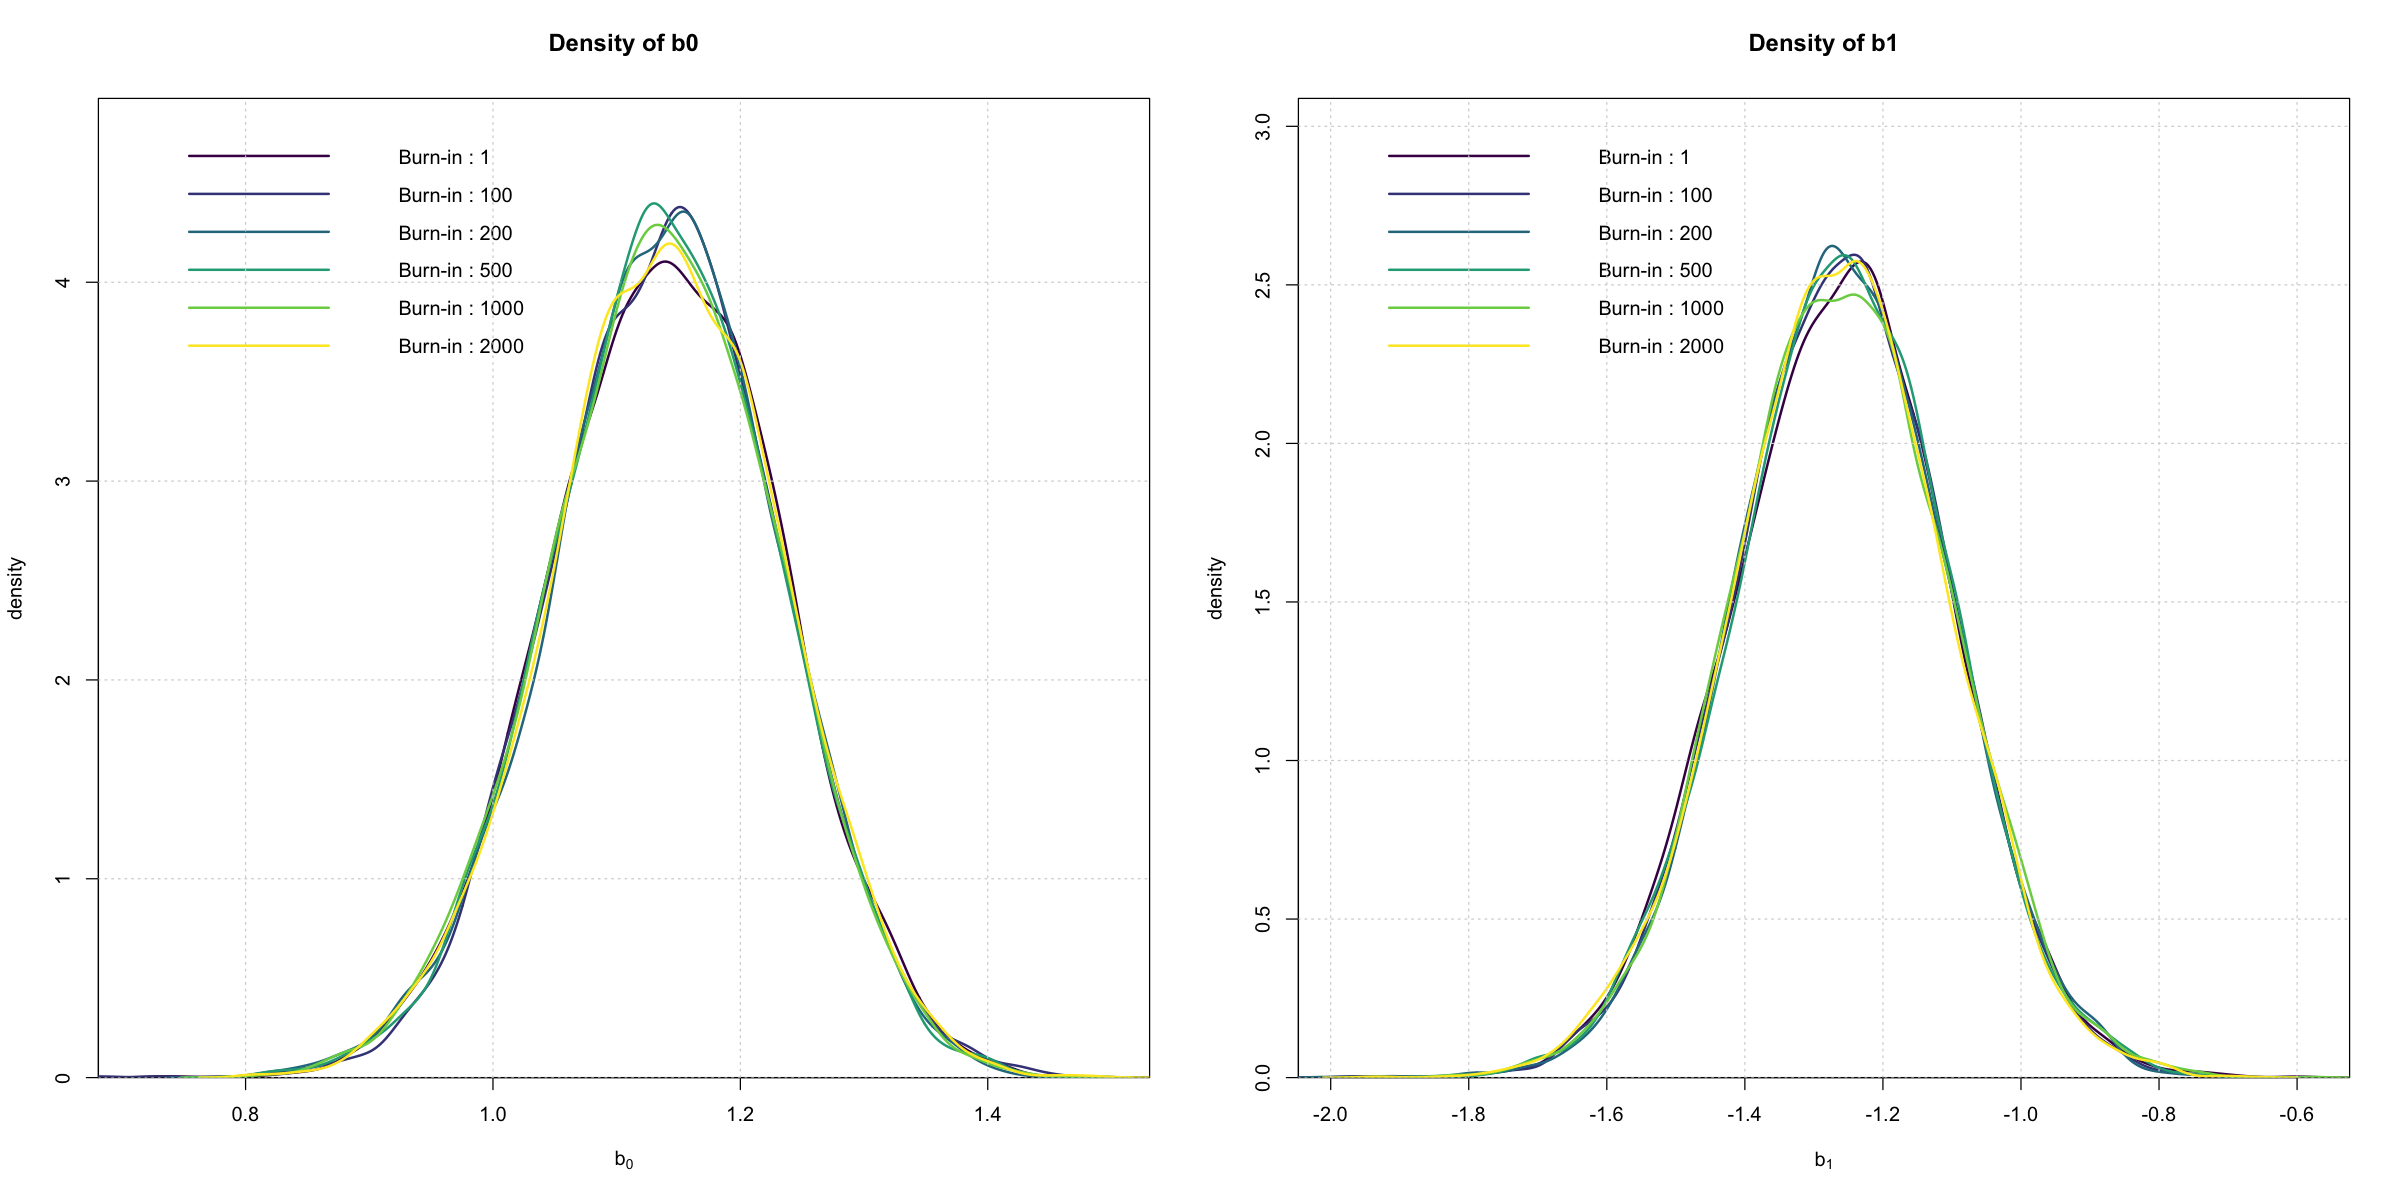

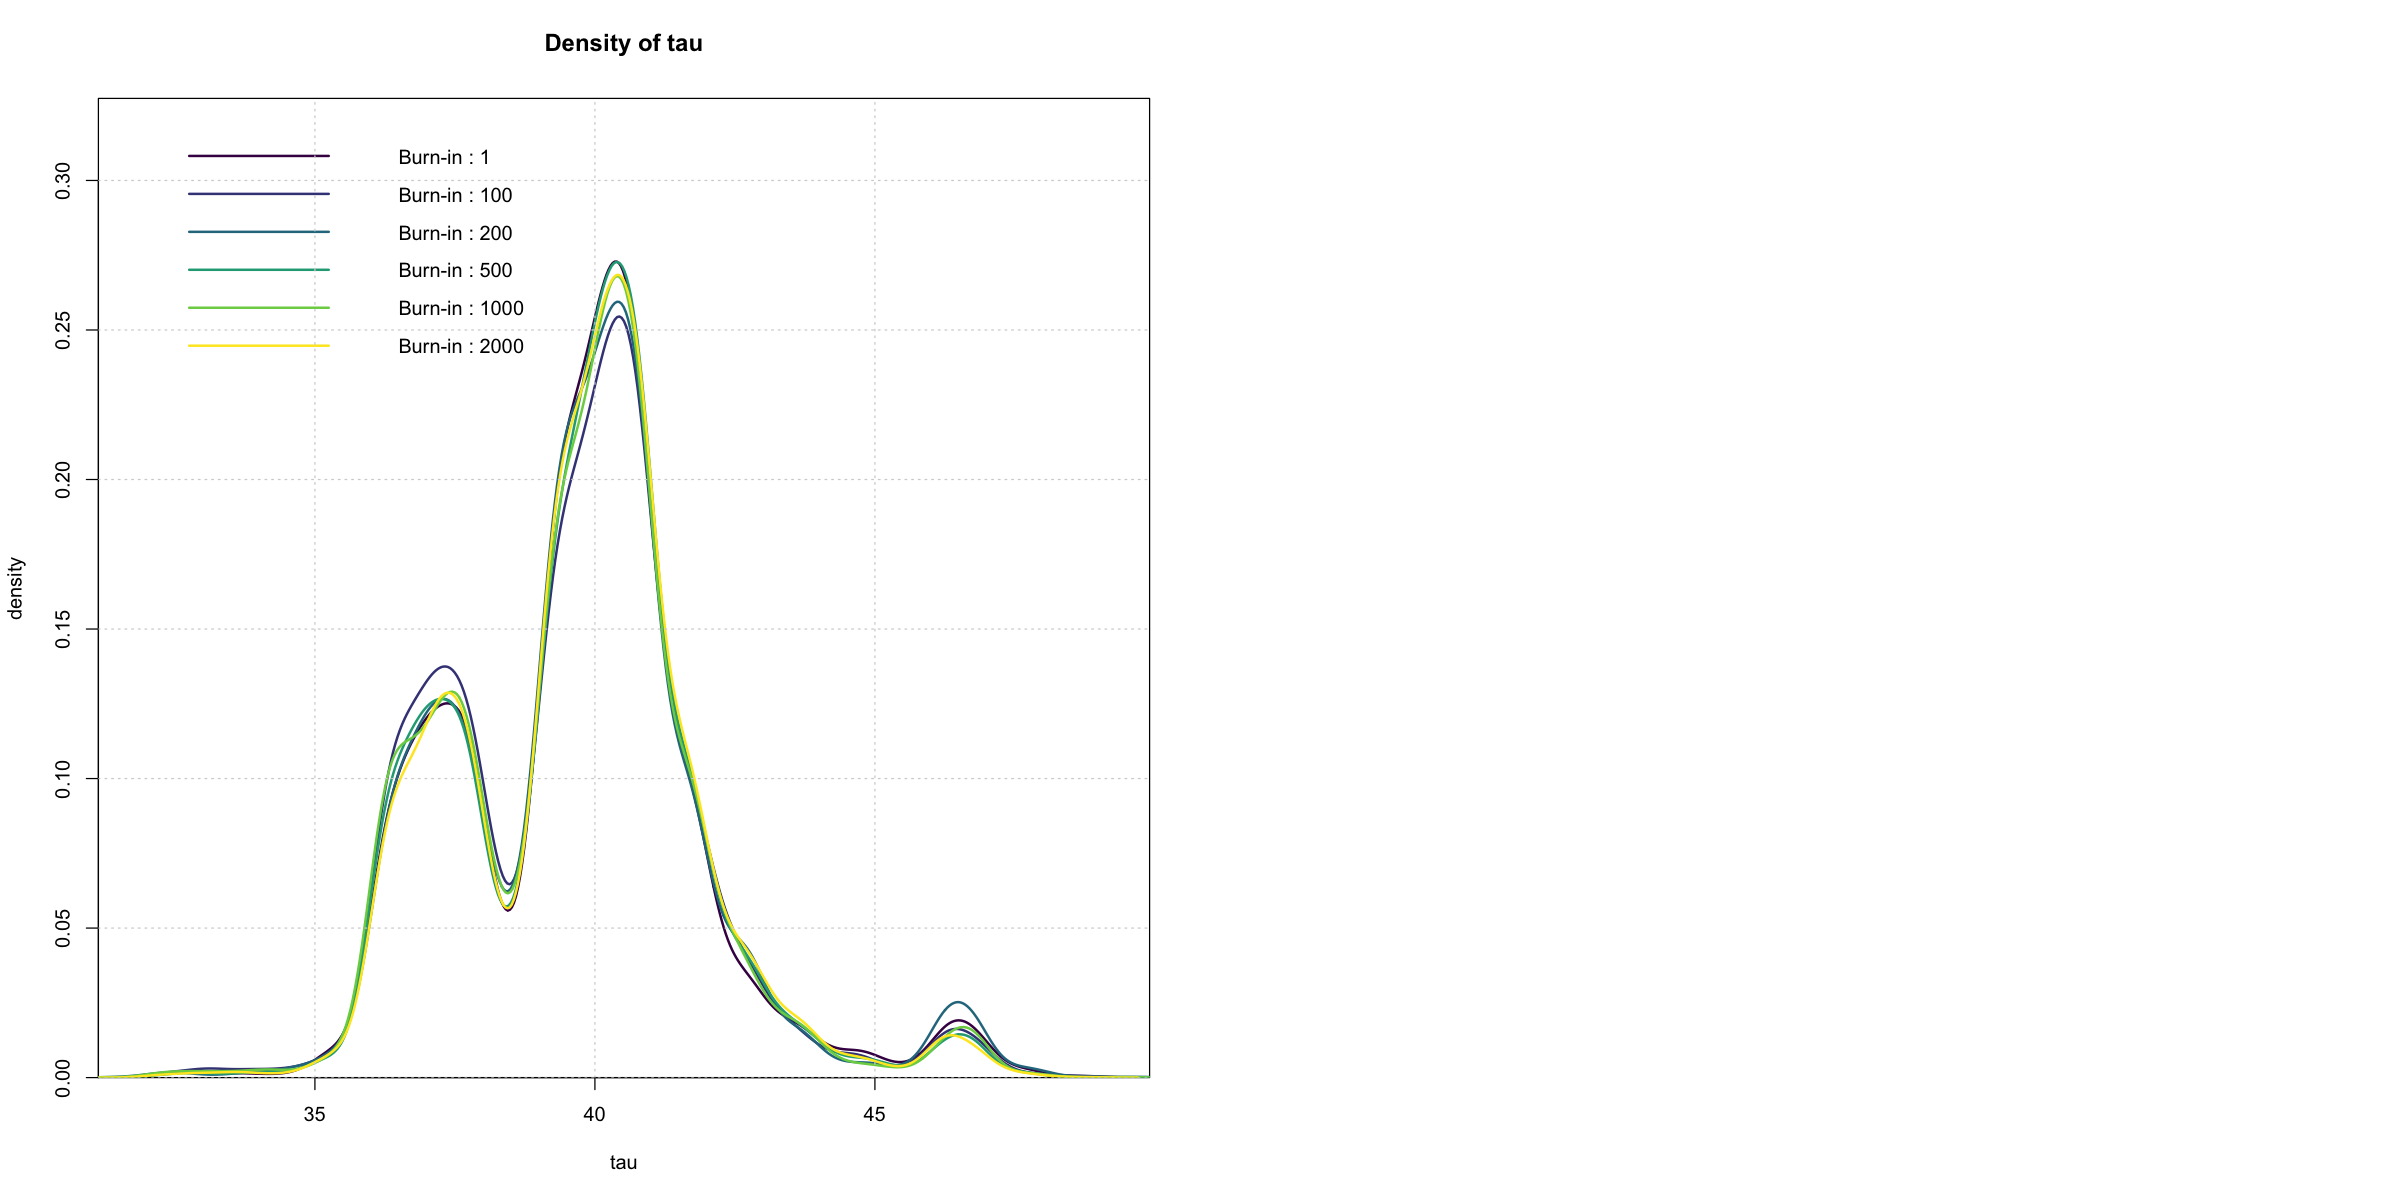

In [32]:
# set the size and position of the plot
par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=10)   

colors = viridis(length(burnin.list))



for (i in 1:length(burnin.list)) {
    d.b0 <- density(b0.burnin.list[,i])
    if (i==1) {
        plot(d.b0$x, d.b0$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.b0$y)), 
             xlab=expression(b[0]), ylab="density")
    } else {
        lines(d.b0$x, d.b0$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("topleft", inset=0.02, legend=paste0(rep("Burn-in : ", length(burnin.list)), as.character(burnin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of b0", line=2)
grid()



for (i in 1:length(burnin.list)) {
    d.b1 <- density(b1.burnin.list[,i])
    if (i==1) {
        plot(d.b1$x, d.b1$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.b1$y)), 
             xlab=expression(b[1]), ylab="density")
    } else {
        lines(d.b1$x, d.b1$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("topleft", inset=0.02, legend=paste0(rep("Burn-in : ", length(burnin.list)), as.character(burnin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of b1", line=2)
grid()



for (i in 1:length(burnin.list)) {
    d.tau <- density(tau.burnin.list[,i])
    if (i==1) {
        plot(d.tau$x, d.tau$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.tau$y)), 
             xlab=expression("tau"), ylab="density")
    } else {
        lines(d.tau$x, d.tau$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("topleft", inset=0.02, legend=paste0(rep("Burn-in : ", length(burnin.list)), as.character(burnin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of tau", line=2)
grid()

#### Thin effect

In [33]:
thin.list <- c(1,2,5,10,25,50,200)

b0.thin.list  <- NULL
b1.thin.list  <- NULL
tau.thin.list <- NULL

In [34]:
for (thin in thin.list) {
    
    model <- "poisson_model.bug"

    # Initialize parameters
    init <- NULL
    init$b0 <- 0
    init$b1 <- 0
    init$tau <- 50

    jm <- jags.model(model, data, init)

    # Update the Markov chain (Burn-in)
    update(jm, 1000)
    
    # Run model
    chain <- coda.samples(jm, c("b0","b1","tau"), n.iter=10000, n.thin=thin, n.adapt=0)

    # Create dataframe
    chain.df <- as.data.frame( as.mcmc(chain) )
    
    # Store results 
    b0.thin.list  <- cbind(b0.thin.list,  chain.df[[1]])
    b1.thin.list  <- cbind(b1.thin.list,  chain.df[[2]])
    tau.thin.list <- cbind(tau.thin.list, chain.df[[3]])
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic no

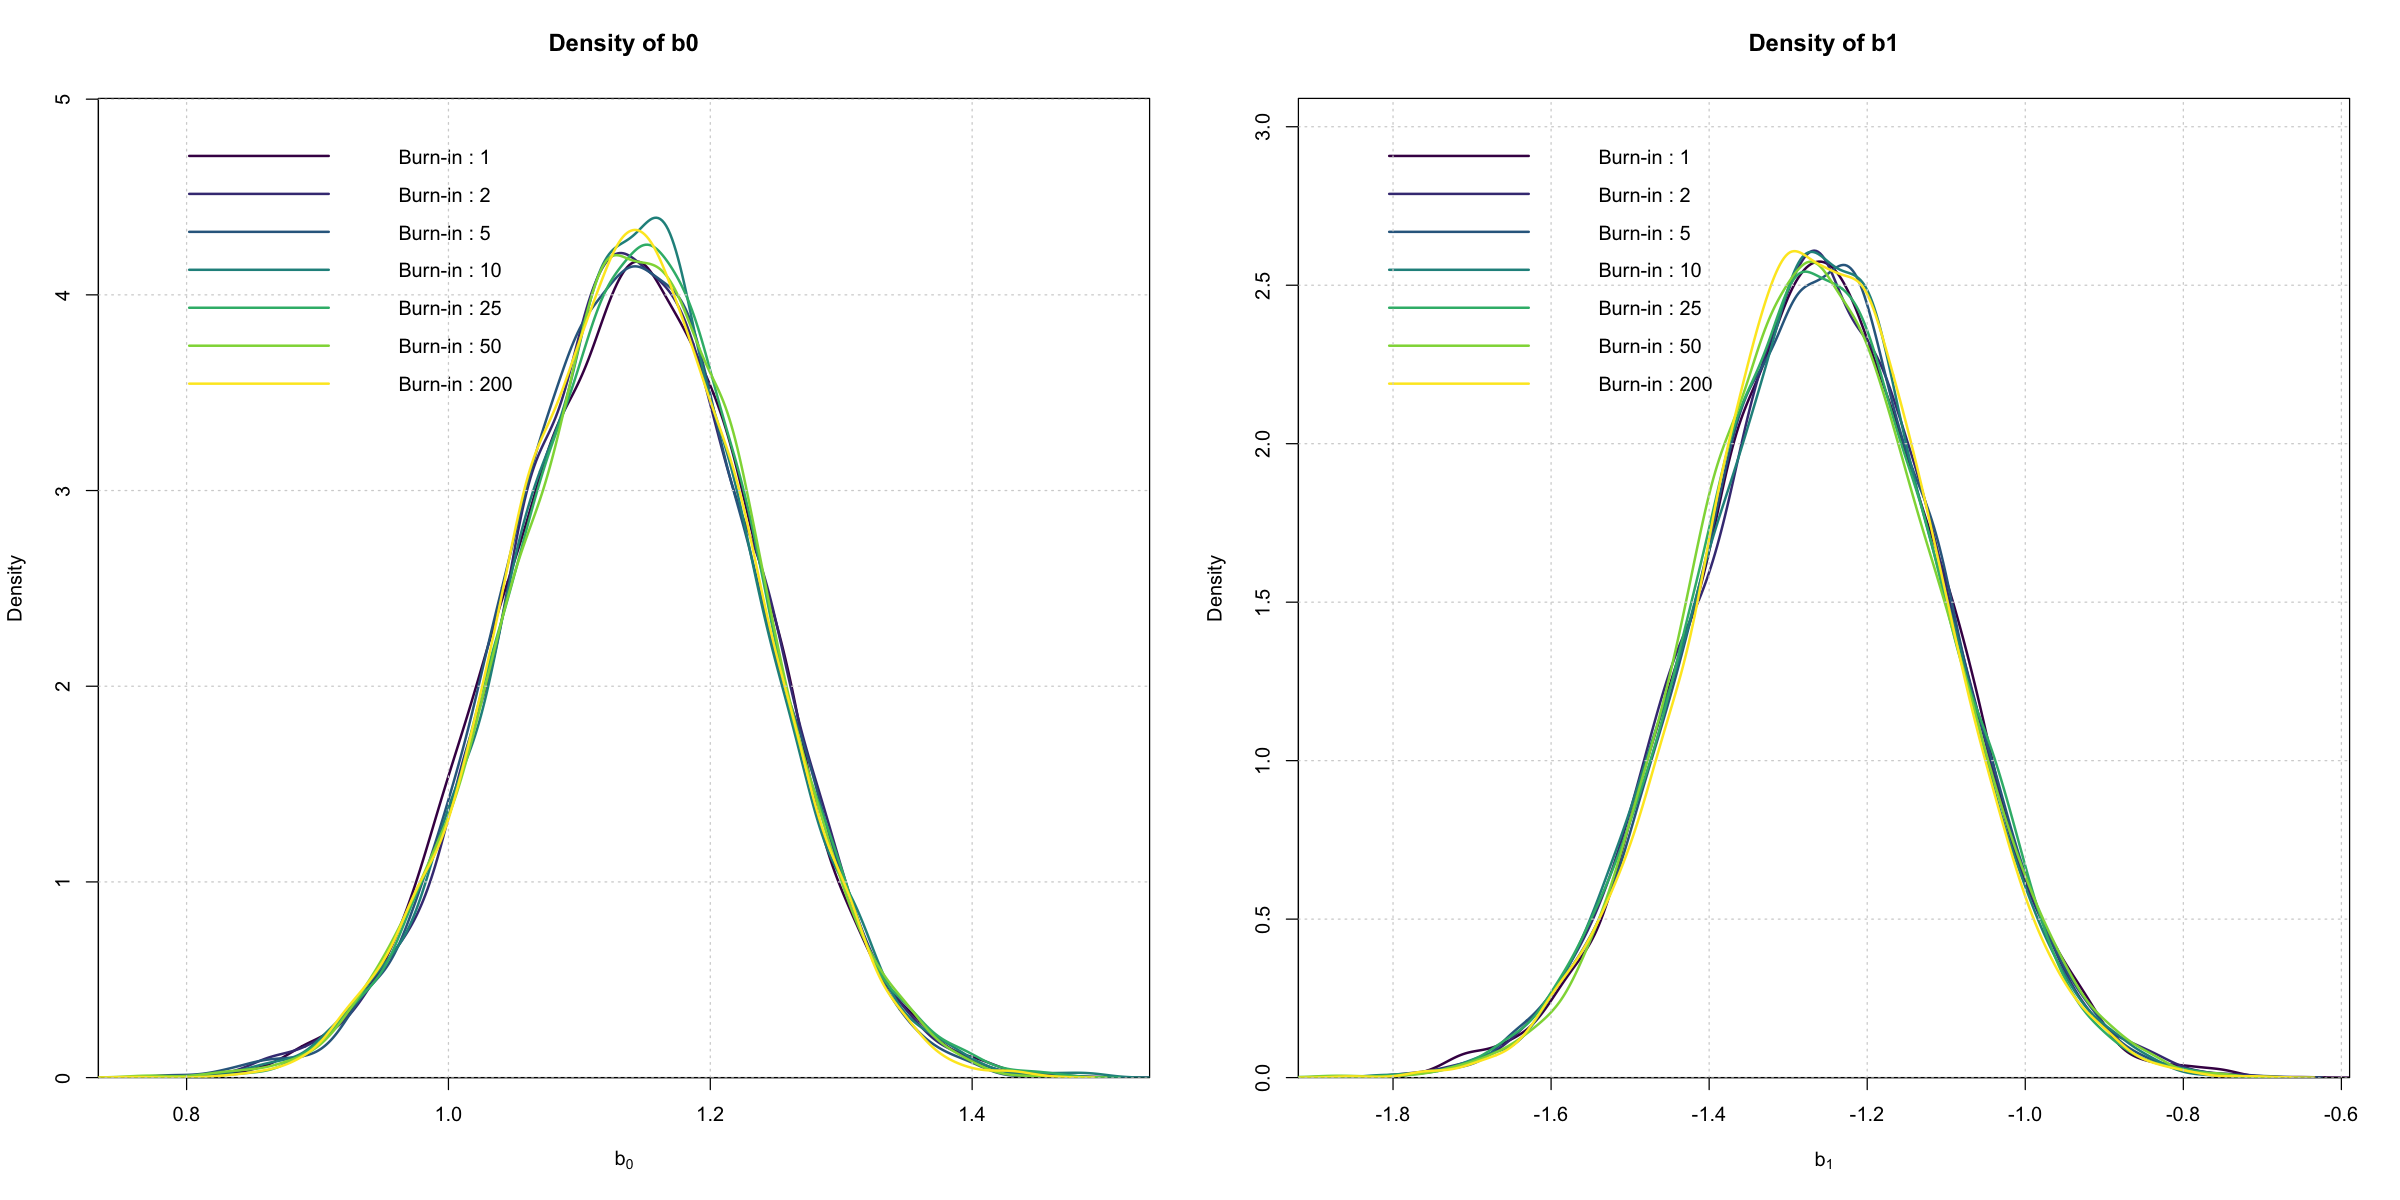

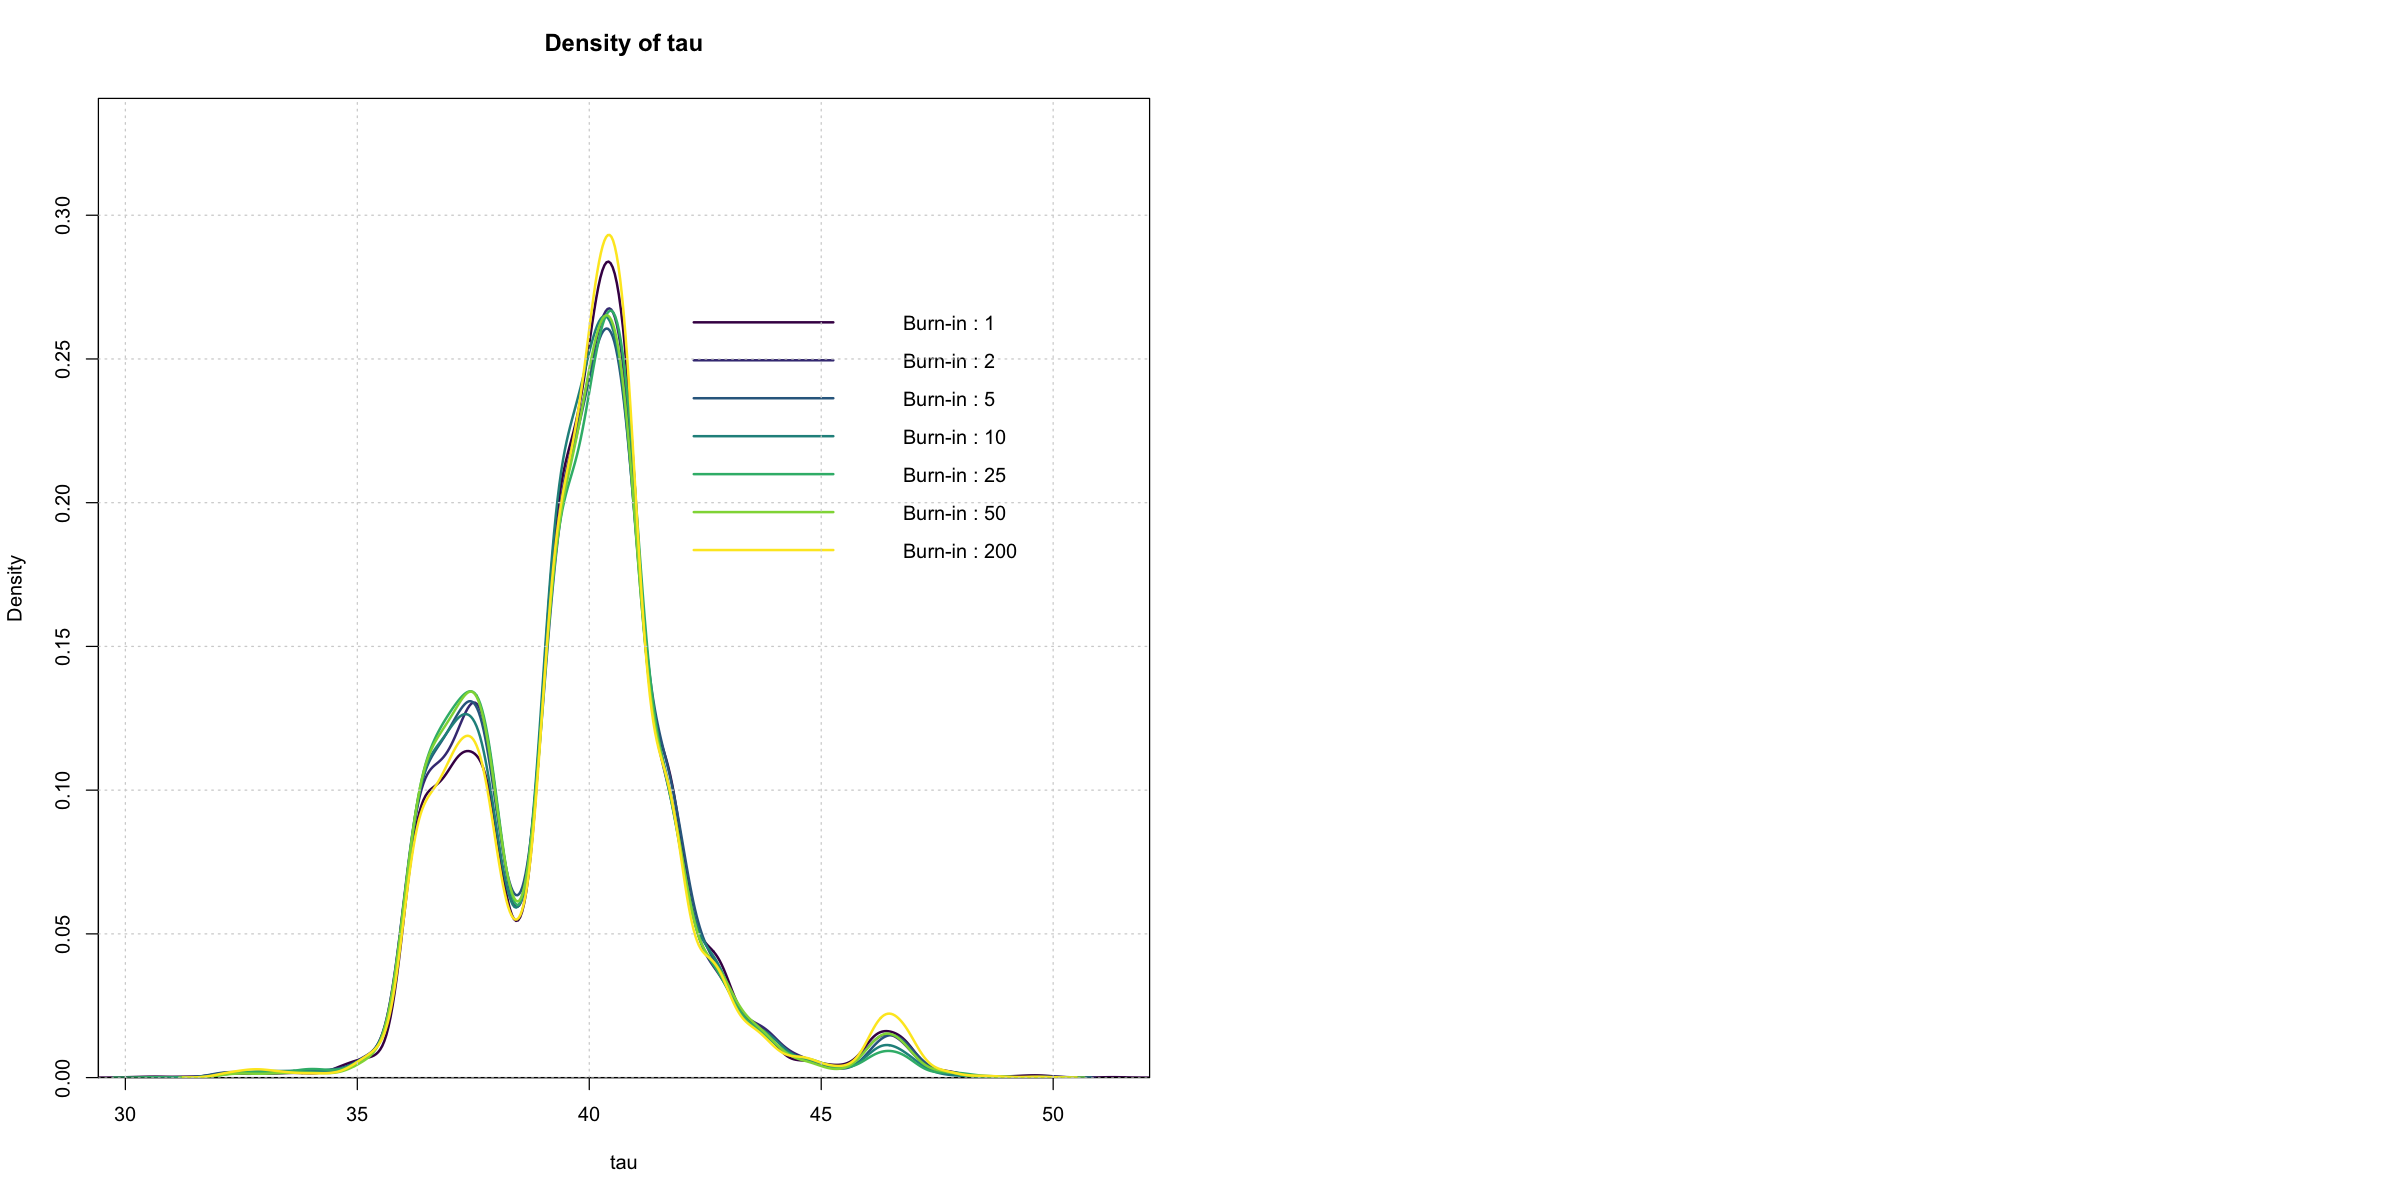

In [35]:
# set the size and position of the plot
par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=10)   

colors = viridis(length(thin.list))



for (i in 1:length(thin.list)) {
    d.b0 <- density(b0.thin.list[,i])
    if (i==1) {
        plot(d.b0$x, d.b0$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.b0$y)), 
             xlab=expression(b[0]), ylab="Density")
    } else {
        lines(d.b0$x, d.b0$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("topleft", inset=0.02, legend=paste0(rep("Burn-in : ", length(thin.list)), as.character(thin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of b0", line=2)
grid()



for (i in 1:length(thin.list)) {
    d.b1 <- density(b1.thin.list[,i])
    if (i==1) {
        plot(d.b1$x, d.b1$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.b1$y)), 
             xlab=expression(b[1]), ylab="Density")
    } else {
        lines(d.b1$x, d.b1$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("topleft", inset=0.02, legend=paste0(rep("Burn-in : ", length(thin.list)), as.character(thin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of b1", line=2)
grid()



for (i in 1:length(thin.list)) {
    d.tau <- density(tau.thin.list[,i])
    if (i==1) {
        plot(d.tau$x, d.tau$y, xaxs='i', yaxs='i', col=colors[i], type='l', lty=1, lwd=2, ylim=c(0,1.2*max(d.tau$y)), 
             xlab=expression("tau"), ylab="Density")
    } else {
        lines(d.tau$x, d.tau$y, col=colors[i], type='l', lty=1, lwd=2)
    }
    
}
legend("bottomleft", inset=0.5, legend=paste0(rep("Burn-in : ", length(thin.list)), as.character(thin.list)),
       col=colors, lty=1:1, lwd=2, cex=1,box.lty=0)

title("Density of tau", line=2)
grid()

### Plot the posterior distributions of the parameters and extract their mean values, and 95% credibility intervals.

In [36]:
model <- "poisson_model.bug"

# Initialize parameters
init <- NULL
init$b0 <- 0
init$b1 <- 0
init$tau <- 50

jm <- jags.model(model, data, init)

# Update the Markov chain (Burn-in)
update(jm, 1000)
    
# Run model
chain <- coda.samples(jm, c("b0","b1","tau"), n.iter=10000, n.thin=thin, n.adapt=0)

# Create dataframe
chain.df <- as.data.frame( as.mcmc(chain) )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model



In [37]:
b0.post  <- density(chain.df[[1]])
b1.post  <- density(chain.df[[2]])
tau.post <- density(chain.df[[3]])

b0.dx  <- b0.post$x[2] - b0.post$x[1]
b1.dx  <- b1.post$x[2] - b1.post$x[1]
tau.dx <- tau.post$x[2] - tau.post$x[1]

In [38]:
# Compute posterior mean and variance
b0.mean <- b0.dx * sum(b0.post$x * b0.post$y)
b0.var  <- b0.dx * sum((b0.post$x**2) * b0.post$y) - (b0.dx * sum(b0.post$x * b0.post$y))**2

b1.mean <- b1.dx * sum(b1.post$x * b1.post$y)
b1.var  <- b1.dx * sum((b1.post$x**2) * b1.post$y) - (b1.dx * sum(b1.post$x * b1.post$y))**2

tau.mean <- tau.dx * sum(tau.post$x * tau.post$y)
tau.var  <- tau.dx * sum((tau.post$x**2) * tau.post$y) - (tau.dx * sum(tau.post$x * tau.post$y))**2

cat("b0 mean     :", b0.mean,'\n')
cat("b0 variance :", b0.var,'\n\n')

cat("b1 mean     :", b1.mean,'\n')
cat("b1 variance :", b1.var,'\n\n')

cat("tau mean    :", tau.mean,'\n')
cat("tau variance:", tau.var,'\n\n')


b0 mean     : 1.142142 
b0 variance : 0.007773482 

b1 mean     : -1.266712 
b1 variance : 0.02336626 

tau mean    : 39.79072 
tau variance: 3.356604 



In [39]:
# Compute most probable value 
b0.max   <- b0.post$x[which.max(b0.post$y)]
b1.max   <- b1.post$x[which.max(b1.post$y)]
tau.max  <- tau.post$x[which.max(tau.post$y)]

cat("b0 max  :", b0.max,'\n')
cat("b1 max  :", b1.max,'\n')
cat("tau max :", tau.max,'\n')

b0 max  : 1.13313 
b1 max  : -1.279031 
tau max : 40.39658 


In [40]:
# Evaluate 95% credibility interval for Posterior

cl = 0.95 # Confidence level

cl.func <- function(p,cumsum.area,cl) {
            x1 <- NULL
            x2 <- NULL
            for(i in 1:(length(cumsum.area)-1)){
                cl1 <- (1-cl)/2
                cl2 <- cl+(1-cl)/2
                if ( (cumsum.area[i+1]>= cl1) & (cumsum.area[i] <= cl1)) {
                    x1 <- (p[i]+p[i+1])/2
                }
                if ( (cumsum.area[i+1]>= cl2) & (cumsum.area[i] <= cl2)) {
                    x2 <- (p[i]+p[i+1])/2
                }            
            }
            return(c(x1,x2))
           }


b0.area  <- b0.dx*cumsum(b0.post$y)
b1.area  <- b1.dx*cumsum(b1.post$y)
tau.area <- tau.dx*cumsum(tau.post$y)

b0.x  <- cl.func(b0.post$x,b0.area,cl)
b1.x  <- cl.func(b1.post$x,b1.area,cl)
tau.x <- cl.func(tau.post$x,tau.area,cl)

cat("b0 Posterior  :\t", 'x1=', b0.x[1],'\tx2=', b0.x[2],'\n')
cat("b1 Posterior  :\t", 'x1=', b1.x[1],'\tx2=', b1.x[2],'\n')
cat("tau Posterior :\t", 'x1=', tau.x[1],'\tx2=', tau.x[2],'\n')

b0 Posterior  :	 x1= 0.9489779 	x2= 1.318835 
b1 Posterior  :	 x1= -1.573848 	x2= -0.9614271 
tau Posterior :	 x1= 35.97572 	x2= 45.73606 


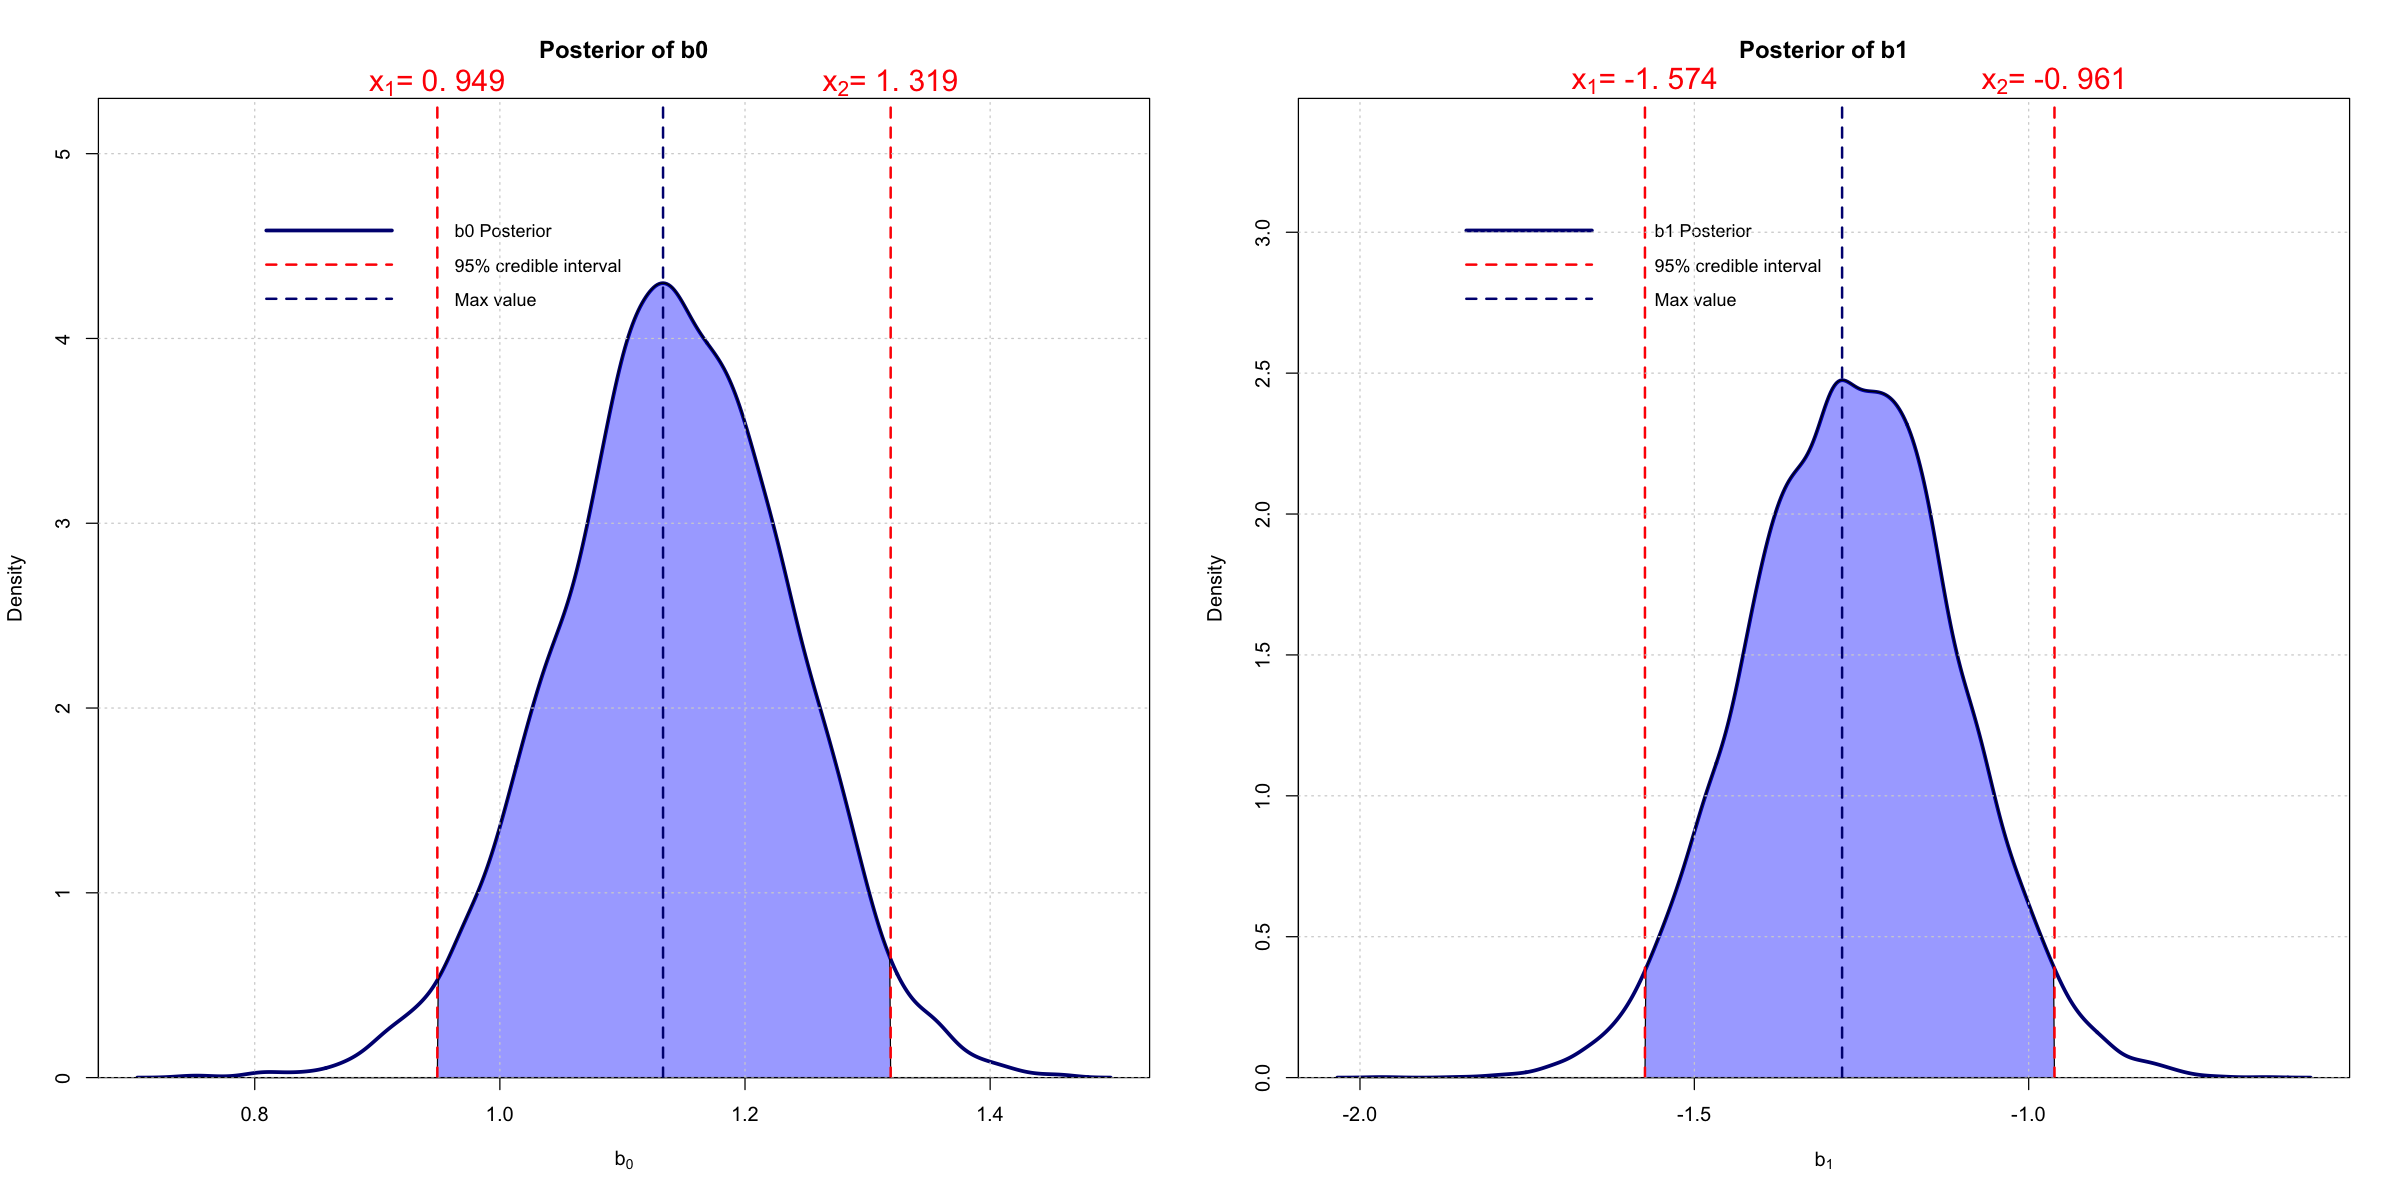

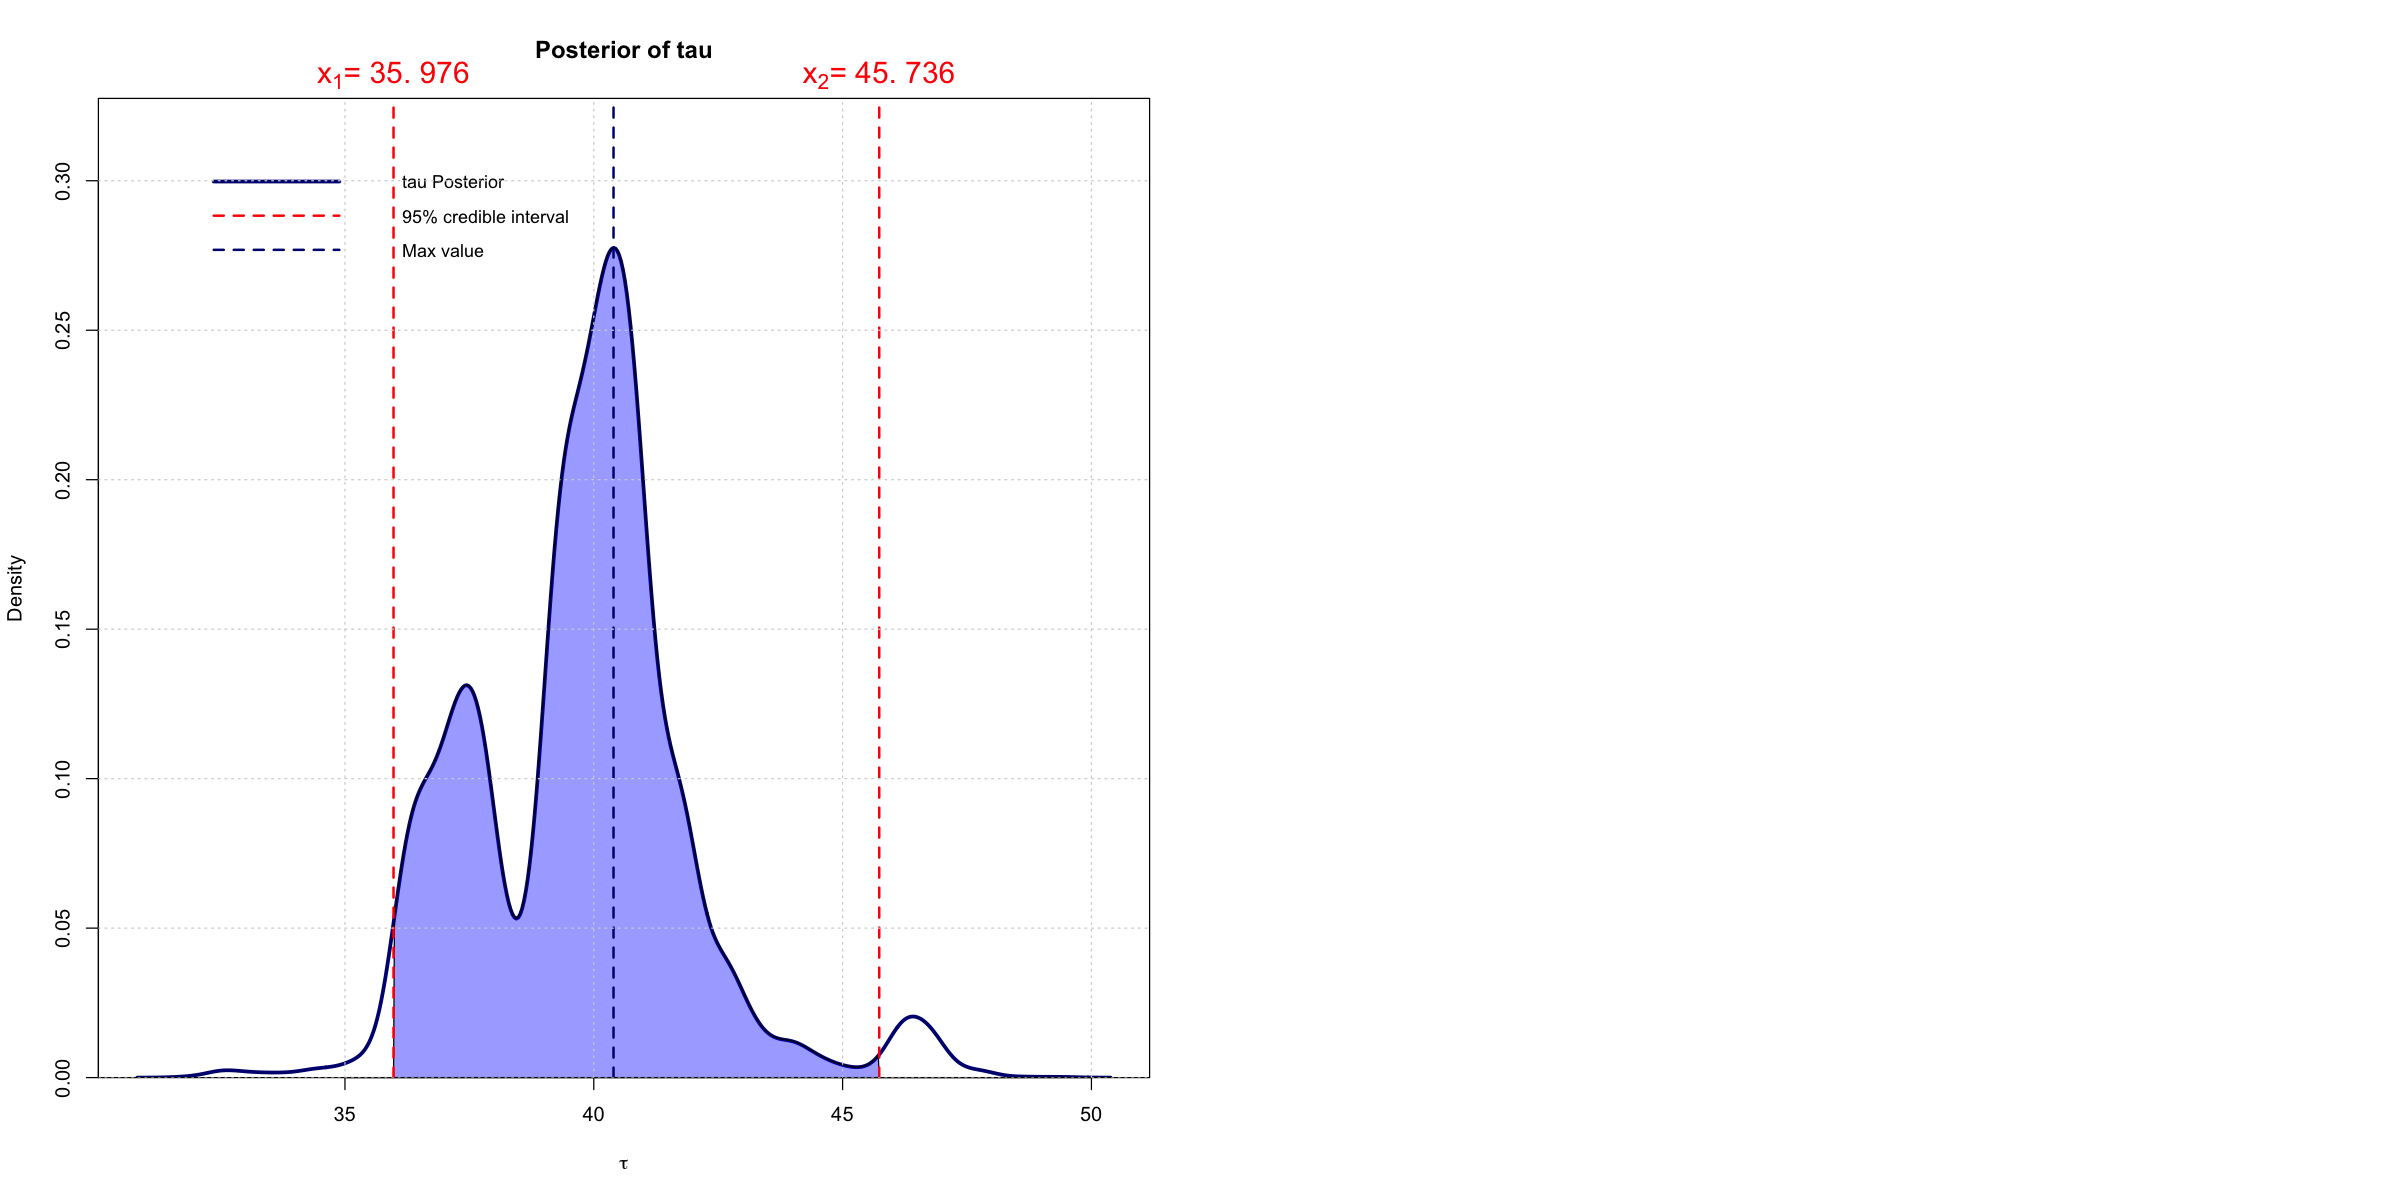

In [41]:
# set the size and position of the plots
par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=10)

# b0 Posterior
plot(b0.post$x, b0.post$y, xaxs='r', yaxs='i', col='navy', type='l', ylim=c(0,max(b0.post$y)+1),
     main = "Posterior of b0", lty=1, lwd = 3, xlab=TeX(sprintf("$b_0$")), ylab='Density')

x = b0.x

xp <- c(x[1],b0.post$x[b0.post$x>x[1] & b0.post$x<x[2]],x[2])
yp <- c(0,b0.post$y[which(b0.post$x>x[1] & b0.post$x<x[2])],0)
polygon(x = xp, y = yp, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.4))

abline(v=x[1], lty=2, col='red', lwd=2)
abline(v=x[2], lty=2, col='red', lwd=2)
abline(v=b0.max, lty=2, col='navy', lwd=2)

text(x[1], par("usr")[4] + 0.2, labels = TeX(sprintf("$x_1$= %0.3f",x[1])), pos=1, cex=1.5, col="red", xpd=TRUE)
text(x[2], par("usr")[4] + 0.2, labels = TeX(sprintf("$x_2$= %0.3f",x[2])), pos=1, cex=1.5, col="red", xpd=TRUE)

legend("topleft", inset=+0.1,legend=c("b0 Posterior","95% credible interval","Max value"),
       col=c("navy","red","navy"), lty=c(1,2,2), lwd=c(3,2,2),cex=0.9,box.lty=0)

grid()


# b1 Posterior
plot(b1.post$x, b1.post$y, xaxs='r', yaxs='i', col='navy', type='l', ylim=c(0,max(b1.post$y)+1),
     main = "Posterior of b1", lty=1, lwd = 3, xlab=TeX(sprintf("$b_1$")), ylab='Density')

x = b1.x

xp <- c(x[1],b1.post$x[b1.post$x>x[1] & b1.post$x<x[2]],x[2])
yp <- c(0,b1.post$y[which(b1.post$x>x[1] & b1.post$x<x[2])],0)
polygon(x = xp, y = yp, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.4))

abline(v=x[1], lty=2, col='red', lwd=2)
abline(v=x[2], lty=2, col='red', lwd=2)
abline(v=b1.max, lty=2, col='navy', lwd=2)

text(x[1], par("usr")[4] + 0.14, labels = TeX(sprintf("$x_1$= %0.3f",x[1])), pos=1, cex=1.5, col="red", xpd=TRUE)
text(x[2], par("usr")[4] + 0.14, labels = TeX(sprintf("$x_2$= %0.3f",x[2])), pos=1, cex=1.5, col="red", xpd=TRUE)

legend("topleft", inset=+0.1,legend=c("b1 Posterior","95% credible interval","Max value"),
       col=c("navy","red","navy"), lty=c(1,2,2), lwd=c(3,2,2),cex=0.9,box.lty=0)

grid()


# tau Posterior
plot(tau.post$x, tau.post$y, xaxs='r', yaxs='i', col='navy', type='l', ylim=c(0,max(tau.post$y)+0.05),
     main = "Posterior of tau", lty=1, lwd = 3, xlab=TeX(sprintf("$\\tau$")), ylab='Density')

x = tau.x

xp <- c(x[1],tau.post$x[tau.post$x>x[1] & tau.post$x<x[2]],x[2])
yp <- c(0,tau.post$y[which(tau.post$x>x[1] & tau.post$x<x[2])],0)
polygon(x = xp, y = yp, col = rgb(red = 0, green = 0, blue = 1, alpha = 0.4))

abline(v=x[1], lty=2, col='red', lwd=2)
abline(v=x[2], lty=2, col='red', lwd=2)
abline(v=tau.max, lty=2, col='navy', lwd=2)

text(x[1], par("usr")[4] + 0.015, labels = TeX(sprintf("$x_1$= %0.3f",x[1])), pos=1, cex=1.5, col="red", xpd=TRUE)
text(x[2], par("usr")[4] + 0.015, labels = TeX(sprintf("$x_2$= %0.3f",x[2])), pos=1, cex=1.5, col="red", xpd=TRUE)

legend("topleft", inset=+0.05,legend=c("tau Posterior","95% credible interval","Max value"),
       col=c("navy","red","navy"), lty=c(1,2,2), lwd=c(3,2,2),cex=0.9,box.lty=0)

grid()